In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from warnings import filterwarnings
import shap
filterwarnings('ignore')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# Data Preprocessing

In [2]:
# Market Clearing Price / Piyasa Takas Fiyatı
mcp1 = pd.read_csv('/content/Piyasa_Takas_Fiyati-30102023-30102024.csv', sep=';')
mcp2 = pd.read_csv('/content/Piyasa_Takas_Fiyati-30102024-30102025.csv', sep=';')
mcp = pd.concat([mcp1, mcp2], axis=0)
mcp.head()

Tarih   Saat PTF (TL/MWh) PTF (USD/MWh) PTF (EUR/MWh)
0  30.10.2023  00:00     1.877,99         66,77         63,25
1  30.10.2023  01:00     2.319,00         82,45         78,11
2  30.10.2023  02:00     1.799,97         64,00         60,63
3  30.10.2023  03:00     2.100,00         74,66         70,73
4  30.10.2023  04:00     1.799,97         64,00         60,63

In [3]:
# Production / Üretim
production1 = pd.read_csv('Gercek_Zamanli_Uretim-30102023-30012024.csv', sep=';')
production2 = pd.read_csv('Gercek_Zamanli_Uretim-30012024-30042024.csv', sep=';')
production3 = pd.read_csv('Gercek_Zamanli_Uretim-30042024-30072024.csv', sep=';')
production4 = pd.read_csv('Gercek_Zamanli_Uretim-30072024-30102024.csv', sep=';')
production5 = pd.read_csv('Gercek_Zamanli_Uretim-30102024-30012025.csv', sep=';')
production6 = pd.read_csv('Gercek_Zamanli_Uretim-30012025-30042025.csv', sep=';')
production7 = pd.read_csv('Gercek_Zamanli_Uretim-30042025-30072025.csv', sep=';')
production8 = pd.read_csv('Gercek_Zamanli_Uretim-30072025-30102025.csv', sep=';')

production = pd.concat([production1, production2, production3, production4, production5, production6, production7, production8], axis=0)
production.head()

Tarih   Saat    Toplam Doğal Gaz  Barajlı   Linyit  Akarsu İthal Kömür   Rüzgar Güneş Fuel Oil Jeotermal Asfaltit Kömür Taş Kömür Biyokütle  Nafta  LNG Uluslararası Atık Isı
0  30.10.2023  00:00  29018,05   5336,31  3601,22  5017,91  718,35      8629,8  1978,26     0    87,48   1206,71         211,96    542,96   1013,41      0    0       583,33    90,35
1  30.10.2023  01:00  27831,72   5446,44  2230,86  5108,86  609,64     8801,59  1922,98     0     80,4   1215,07         214,17     545,7   1000,38      0    0        563,7    91,93
2  30.10.2023  02:00   27038,6   5206,16  1645,89  5213,35  528,03     8727,27  1808,66     0     79,8   1222,38         216,38    541,77   1010,78      0    0       743,26    94,87
3  30.10.2023  03:00  26574,14   5188,83   1310,3     5015  474,82      8883,2  1776,25     0    79,67   1226,56         214,17     549,2   1016,82      0    0       751,85    87,47
4  30.10.2023  04:00  26453,59   4983,44  1316,78  5003,02  426,47     8772,16  1750,65     0    79,67   1235,91         216,38    544,38   1030,97      0    0      1005,32    88,44

In [4]:
# Consumption / Tüketim
consumption1 = pd.read_csv('Gercek_Zamanli_Tuketim-30102023-30102024.csv', sep=';')
consumption2 = pd.read_csv('Gercek_Zamanli_Tuketim-30102024-30102025.csv', sep=';')

consumption = pd.concat([consumption1, consumption2], axis=0)
consumption.head()

Tarih   Saat Tüketim Miktarı(MWh)
0  30.10.2023  00:00            29.051,28
1  30.10.2023  01:00            27.868,07
2  30.10.2023  02:00            27.073,08
3  30.10.2023  03:00            26.606,03
4  30.10.2023  04:00            26.483,97

In [5]:
mcp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17592 entries, 0 to 8783
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tarih          17592 non-null  object
 1   Saat           17592 non-null  object
 2   PTF (TL/MWh)   17592 non-null  object
 3   PTF (USD/MWh)  17592 non-null  object
 4   PTF (EUR/MWh)  17592 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


In [6]:
production.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17736 entries, 0 to 2231
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tarih           17736 non-null  object
 1   Saat            17736 non-null  object
 2   Toplam          17736 non-null  object
 3   Doğal Gaz       17736 non-null  object
 4   Barajlı         17736 non-null  object
 5   Linyit          17736 non-null  object
 6   Akarsu          17736 non-null  object
 7   İthal Kömür     17736 non-null  object
 8   Rüzgar          17736 non-null  object
 9   Güneş           17736 non-null  object
 10  Fuel Oil        17736 non-null  object
 11  Jeotermal       17736 non-null  object
 12  Asfaltit Kömür  17736 non-null  object
 13  Taş Kömür       17736 non-null  object
 14  Biyokütle       17736 non-null  object
 15  Nafta           17736 non-null  int64 
 16  LNG             17736 non-null  int64 
 17  Uluslararası    17736 non-null  object
 18  Atık Isı    

In [7]:
production.isnull().sum().sort_values(ascending=False).head(5)

Tarih        0
Saat         0
Toplam       0
Doğal Gaz    0
Barajlı      0
dtype: int64

In [8]:
consumption.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17592 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Tarih                 17592 non-null  object
 1   Saat                  17592 non-null  object
 2   Tüketim Miktarı(MWh)  17592 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


## Duplicated Rows

In [9]:
mcp.drop_duplicates(inplace=True)
production.drop_duplicates(inplace=True)
consumption.drop_duplicates(inplace=True)

## NA Values

In [10]:
mcp.dropna(inplace=True)
production.dropna(inplace=True)
consumption.dropna(inplace=True)

# Type Converting

In [11]:
mcp['Datetime'] = pd.to_datetime(mcp['Tarih'].astype(str) + ' ' + mcp['Saat'].astype(str))
production['Datetime'] = pd.to_datetime(production['Tarih'].astype(str) + ' ' + production['Saat'].astype(str))
consumption['Datetime'] = pd.to_datetime(consumption['Tarih'].astype(str) + ' ' + consumption['Saat'].astype(str))


"""
mcp = mcp.set_index('Datetime')
mcp = mcp.sort_index()
production = production.set_index('Datetime')
production = production.sort_index()
consumption = consumption.set_index('Datetime')
consumption = consumption.sort_index()
mcp = mcp.drop(['Tarih', 'Saat'], axis=1)
production = production.drop(['Tarih', 'Saat'],axis=1)
consumption = consumption.drop(['Tarih', 'Saat'],axis=1)"""


"\nmcp = mcp.set_index('Datetime')\nmcp = mcp.sort_index()\nproduction = production.set_index('Datetime')\nproduction = production.sort_index()\nconsumption = consumption.set_index('Datetime')\nconsumption = consumption.sort_index()\nmcp = mcp.drop(['Tarih', 'Saat'], axis=1)\nproduction = production.drop(['Tarih', 'Saat'],axis=1)\nconsumption = consumption.drop(['Tarih', 'Saat'],axis=1)"

In [12]:
mcp['PTF (TL/MWh)'] = mcp['PTF (TL/MWh)'].str.replace('.','', regex=False).str.replace(',','.', regex=False)
mcp['PTF (TL/MWh)'] = pd.to_numeric(mcp['PTF (TL/MWh)'], errors='coerce')

mcp['PTF (USD/MWh)'] = mcp['PTF (USD/MWh)'].str.replace(',','.', regex=False)
mcp['PTF (USD/MWh)'] = pd.to_numeric(mcp['PTF (USD/MWh)'], errors='coerce')
mcp['PTF (EUR/MWh)'] = mcp['PTF (EUR/MWh)'].str.replace(',','.', regex=False)
mcp['PTF (EUR/MWh)'] = pd.to_numeric(mcp['PTF (EUR/MWh)'], errors='coerce')

consumption['Tüketim Miktarı(MWh)'] = consumption['Tüketim Miktarı(MWh)'].str.replace('.','',regex=False).str.replace(',', '.', regex=False)
consumption['Tüketim Miktarı(MWh)'] = pd.to_numeric(consumption['Tüketim Miktarı(MWh)'], errors='coerce')

In [13]:
change_cols = [col for col in production.columns if col not in ['Datetime', 'Tarih', 'Saat'] and production[col].dtype not in ['int64','float64']]

for col in change_cols:
    production[col] = production[col].str.replace(',','.', regex=False)
    production[col] = pd.to_numeric(production[col], errors='coerce')

In [14]:
mcp.isnull().sum()

Tarih            0
Saat             0
PTF (TL/MWh)     0
PTF (USD/MWh)    0
PTF (EUR/MWh)    0
Datetime         0
dtype: int64

In [15]:
production.describe().T

count                 mean                  min                  25%                  50%                  75%                  max          std
Toplam          17568.0         36525.797676             11175.31            32059.295              36304.5           41022.0975             56219.06  6360.954413
Doğal Gaz       17568.0          7723.795008               276.29             4342.345             7575.245           10753.2975             18756.14  4025.471434
Barajlı         17568.0          5768.344981               394.82            3400.8275             5354.275            7714.0175             16722.49  2960.590317
Linyit          17568.0          4593.932971              1701.42             4282.215              4642.15             4963.895              6277.47   603.940391
Akarsu          17568.0          1957.167973               268.15              1070.32             1611.865            2590.8375               5466.4  1128.102274
İthal Kömür     17568.0          8535.724566               1657.0            7546.5825              9388.54            9973.1025             10172.67  1877.715968
Rüzgar          17568.0          4325.667778               127.05            2311.8925             4049.755               6182.9             10612.45  2361.778929
Güneş           17568.0           717.918095                -2.98                 0.01               40.505            1459.1175              3394.37   954.080558
Fuel Oil        17568.0            85.253297                 26.7                81.53                87.98                92.63               109.22     10.54281
Jeotermal       17568.0          1183.999788                779.2            1085.5525             1211.235             1297.375              1422.37   137.902856
Asfaltit Kömür  17568.0           167.753033                  0.0               114.81               203.13                220.8               346.65    84.859621
Taş Kömür       17568.0           518.192847               215.39              446.255               555.97             591.0325               677.49    89.761158
Biyokütle       17568.0           967.235581               495.19             942.9475               970.84                996.1              1082.43    41.569713
Nafta           17568.0                  0.0                  0.0                  0.0                  0.0                  0.0                  0.0          0.0
LNG             17568.0                  0.0                  0.0                  0.0                  0.0                  0.0                  0.0          0.0
Uluslararası    17568.0          -103.299597             -1147.41            -486.5925               -58.35             178.2225              7875.85   425.685177
Atık Isı        17568.0            84.111356                40.47                76.54               83.905                91.87               116.14    10.926117
Datetime          17568  2024-10-29 23:30:00  2023-10-30 00:00:00  2024-04-29 23:45:00  2024-10-29 23:30:00  2025-04-30 23:15:00  2025-10-30 23:00:00          NaN

In [16]:
production.loc[production['Güneş'] < 0, 'Güneş'] = 0
production = production.drop(['Nafta', 'LNG'], axis=1) # All values of Nafta and LNG are zero.

## Merging Datasets

In [17]:
df = pd.merge(mcp, production,on=['Datetime', 'Tarih', 'Saat'], how='inner')
df = pd.merge(df, consumption, on=['Datetime', 'Tarih', 'Saat'], how= 'inner')

In [18]:
df.head()

Tarih   Saat  PTF (TL/MWh)  PTF (USD/MWh)  PTF (EUR/MWh)            Datetime    Toplam  Doğal Gaz  Barajlı   Linyit  Akarsu  İthal Kömür   Rüzgar  Güneş  Fuel Oil  Jeotermal  Asfaltit Kömür  Taş Kömür  Biyokütle  Uluslararası  Atık Isı  Tüketim Miktarı(MWh)
0  30.10.2023  00:00       1877.99          66.77          63.25 2023-10-30 00:00:00  29018.05    5336.31  3601.22  5017.91  718.35      8629.80  1978.26    0.0     87.48    1206.71          211.96     542.96    1013.41        583.33     90.35              29051.28
1  30.10.2023  01:00       2319.00          82.45          78.11 2023-10-30 01:00:00  27831.72    5446.44  2230.86  5108.86  609.64      8801.59  1922.98    0.0     80.40    1215.07          214.17     545.70    1000.38        563.70     91.93              27868.07
2  30.10.2023  02:00       1799.97          64.00          60.63 2023-10-30 02:00:00  27038.60    5206.16  1645.89  5213.35  528.03      8727.27  1808.66    0.0     79.80    1222.38          216.38     541.77    1010.78        743.26     94.87              27073.08
3  30.10.2023  03:00       2100.00          74.66          70.73 2023-10-30 03:00:00  26574.14    5188.83  1310.30  5015.00  474.82      8883.20  1776.25    0.0     79.67    1226.56          214.17     549.20    1016.82        751.85     87.47              26606.03
4  30.10.2023  04:00       1799.97          64.00          60.63 2023-10-30 04:00:00  26453.59    4983.44  1316.78  5003.02  426.47      8772.16  1750.65    0.0     79.67    1235.91          216.38     544.38    1030.97       1005.32     88.44              26483.97

# Exploratory Data Analysis (EDA)

## Grapping Categorical and Numerical Variables

In [19]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols= [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O' and
                   dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == 'O' and
                   dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat ]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 17568
Variables: 22
cat_cols: 0
num_cols: 20
cat_but_car: 2
num_but_cat: 0


## Correlation Matrix

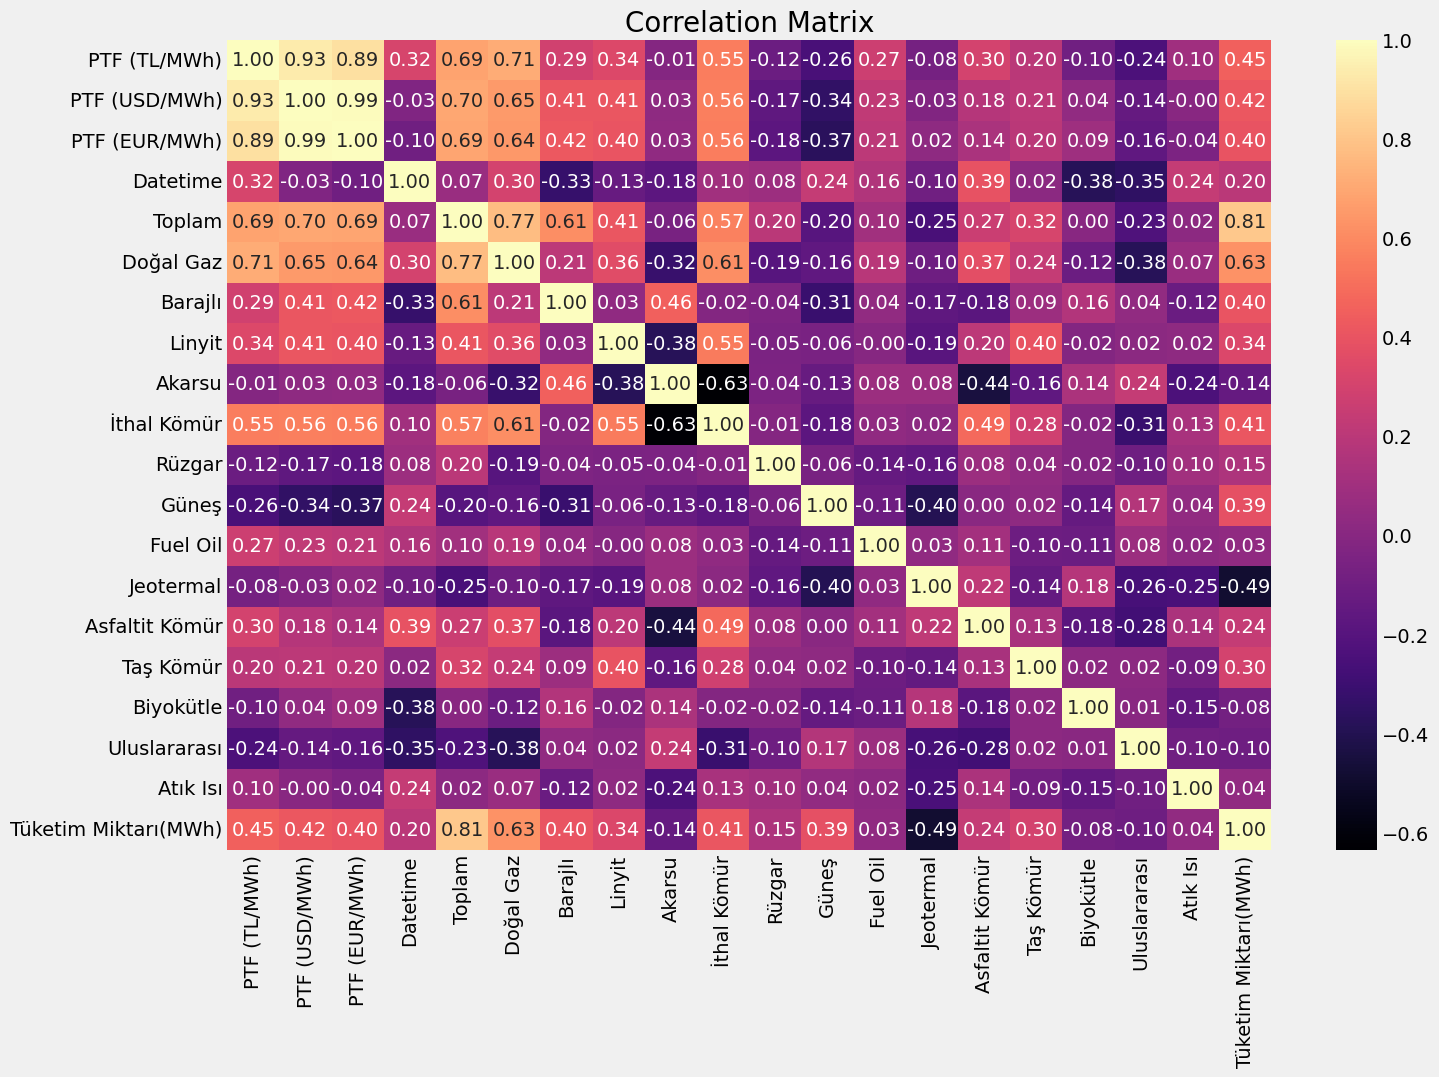

In [20]:
# Numerical Variables
f, ax = plt.subplots(figsize=[15,10])
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', ax=ax, cmap='magma')
ax.set_title('Correlation Matrix', fontsize=20)
plt.show()

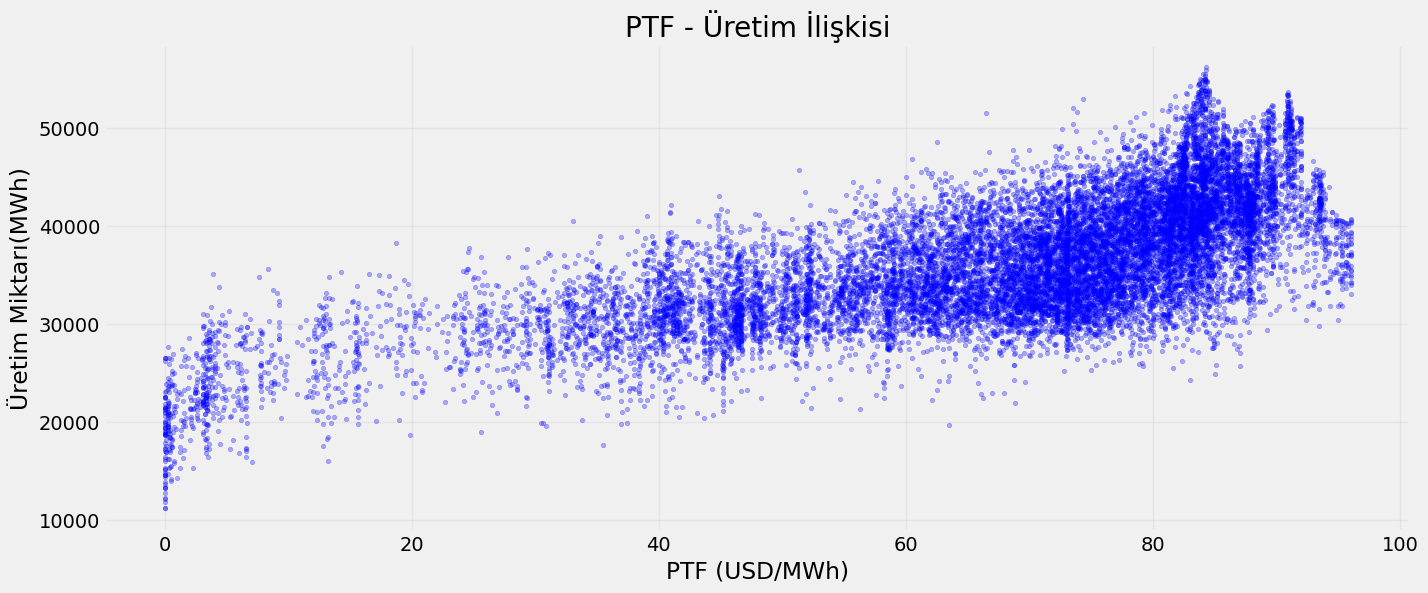

In [21]:
# PTF - Tüketim İlişkisi
plt.figure(figsize=(15, 6))
plt.scatter(df['PTF (USD/MWh)'], df['Toplam'],
            alpha=0.3, s=10, c='blue',marker='o')
plt.xlabel('PTF (USD/MWh)')
plt.ylabel('Üretim Miktarı(MWh)')
plt.title('PTF - Üretim İlişkisi')
plt.grid(True, alpha=0.3)
plt.show()

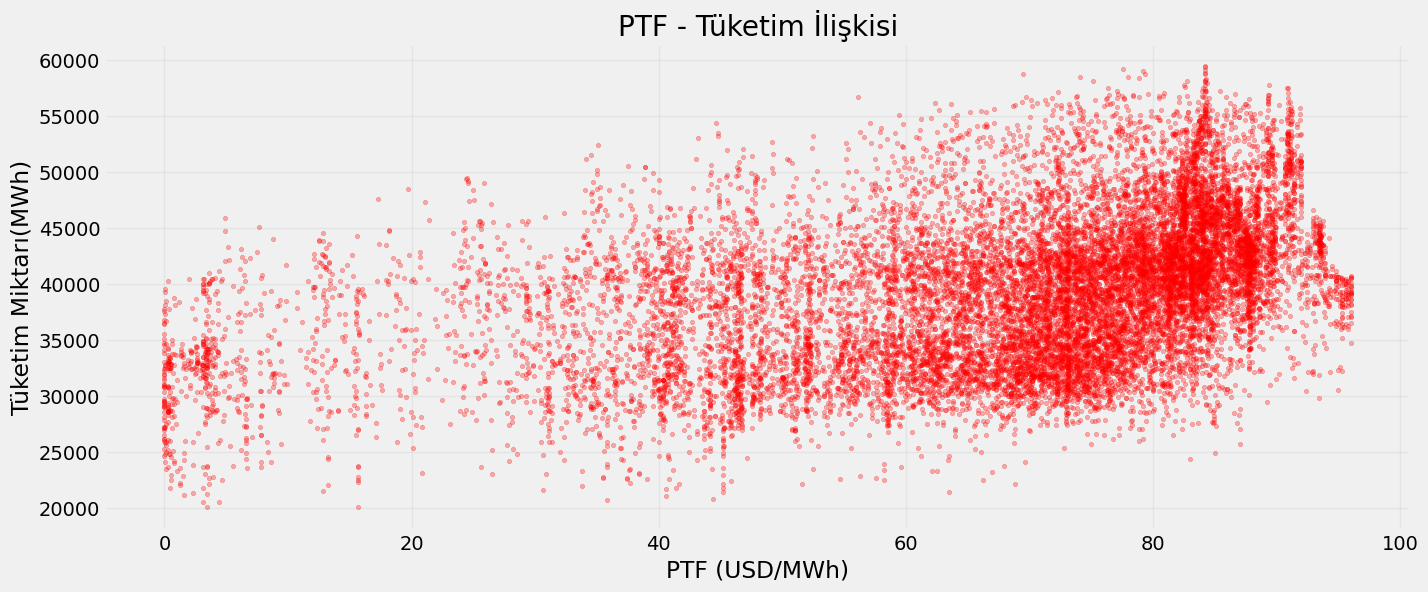

In [22]:
# PTF - Tüketim İlişkisi
plt.figure(figsize=(15, 6))
plt.scatter(df['PTF (USD/MWh)'], df['Tüketim Miktarı(MWh)'],
            alpha=0.3, s=10, c='red',marker='o')
plt.xlabel('PTF (USD/MWh)')
plt.ylabel('Tüketim Miktarı(MWh)')
plt.title('PTF - Tüketim İlişkisi')
plt.grid(True, alpha=0.3)
plt.show()

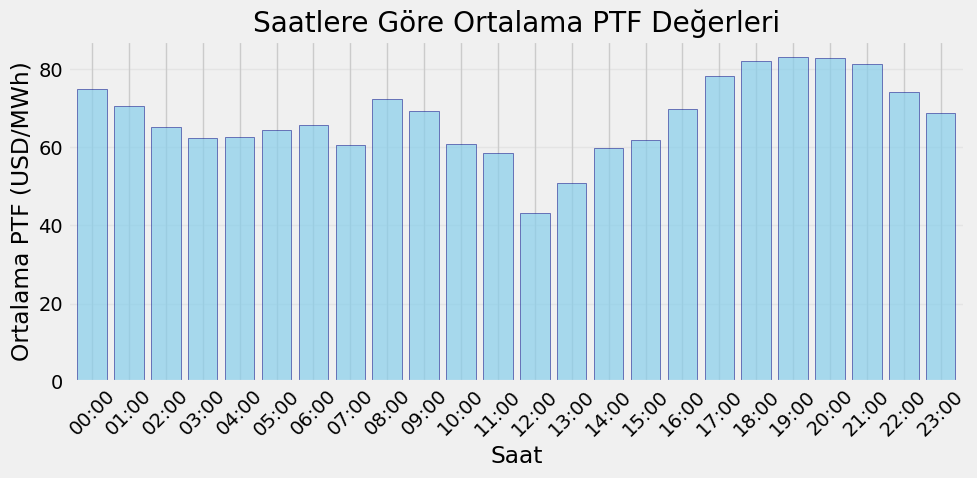

In [23]:
# PTF
plt.figure(figsize=(10, 5))

df.groupby('Saat')['PTF (USD/MWh)'].mean().plot(kind='bar',
                                               color='skyblue',
                                               edgecolor='navy',
                                               alpha=0.7,
                                               width=0.8)

plt.xlabel('Saat')
plt.ylabel('Ortalama PTF (USD/MWh)')
plt.title('Saatlere Göre Ortalama PTF Değerleri')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

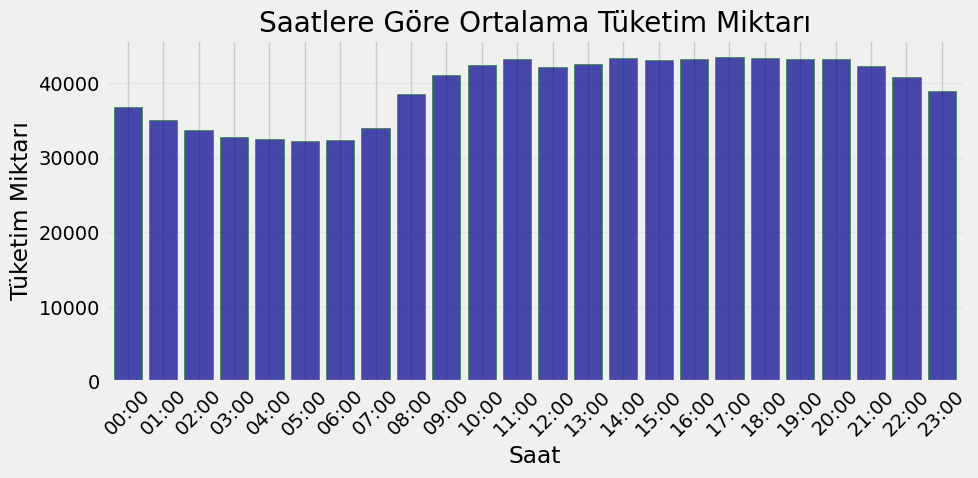

In [24]:
# Consumption
plt.figure(figsize=(10, 5))

df.groupby('Saat')['Tüketim Miktarı(MWh)'].mean().plot(kind='bar',
                                               color='darkblue',
                                               edgecolor='green',
                                               alpha=0.7,
                                               width=0.8)

plt.xlabel('Saat')
plt.ylabel('Tüketim Miktarı')
plt.title('Saatlere Göre Ortalama Tüketim Miktarı')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

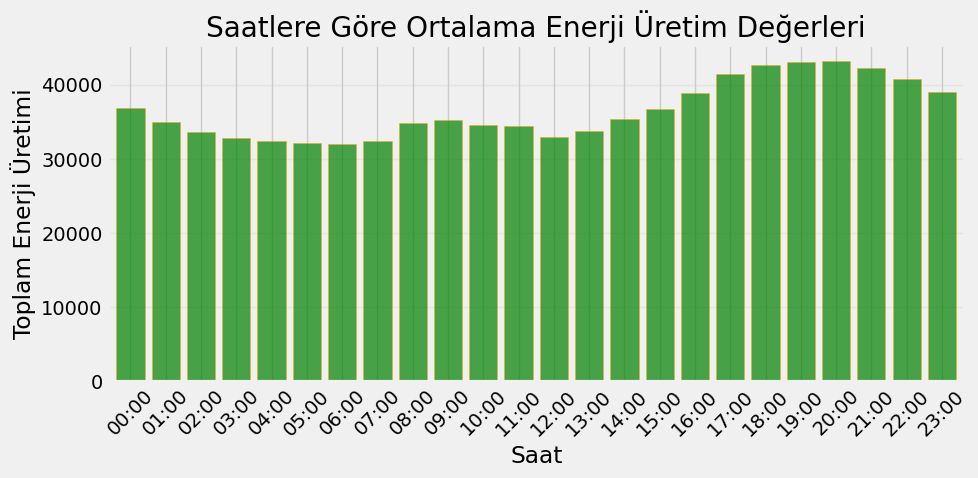

In [25]:
# Production
plt.figure(figsize=(10, 5))

df.groupby('Saat')['Toplam'].mean().plot(kind='bar',
                                               color='green',
                                               edgecolor='orange',
                                               alpha=0.7,
                                               width=0.8)

plt.xlabel('Saat')
plt.ylabel('Toplam Enerji Üretimi')
plt.title('Saatlere Göre Ortalama Enerji Üretim Değerleri')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

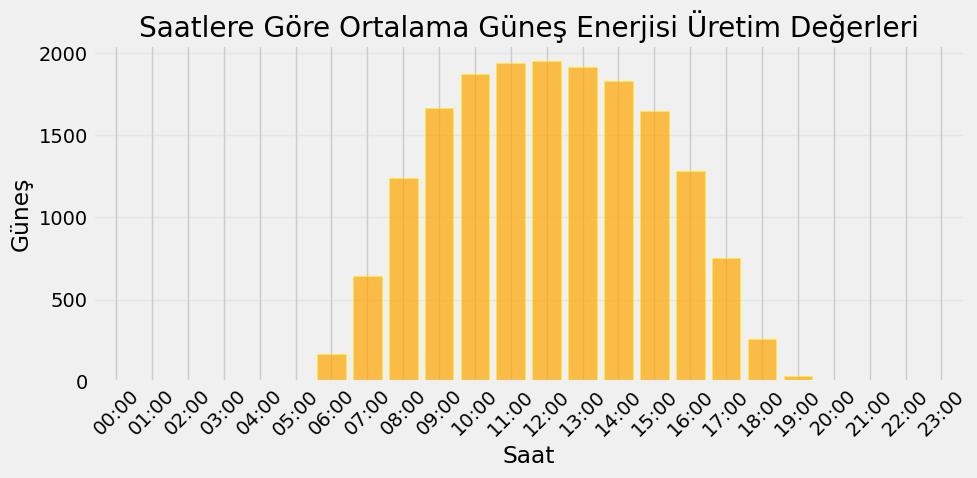

In [26]:
# Sun Effect
plt.figure(figsize=(10, 5))

df.groupby('Saat')['Güneş'].mean().plot(kind='bar',
                                               color='orange',
                                               edgecolor='yellow',
                                               alpha=0.7,
                                               width=0.8)

plt.xlabel('Saat')
plt.ylabel('Güneş')
plt.title('Saatlere Göre Ortalama Güneş Enerjisi Üretim Değerleri')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

count    17568.000000
mean      2359.392926
std        743.860026
min          0.000000
5%         980.000000
25%       2000.000000
40%       2325.838000
50%       2496.000000
60%       2657.398000
75%       2920.000000
95%       3399.000000
max       3400.000000
Name: PTF (TL/MWh), dtype: float64


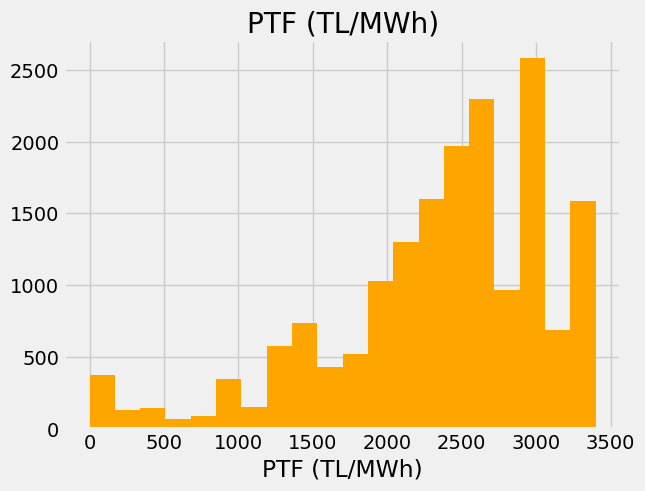


count    17568.000000
mean        67.642822
std         20.076237
min          0.000000
5%          26.027000
25%         59.087500
40%         69.420000
50%         73.180000
60%         76.930000
75%         82.300000
95%         89.260000
max         96.000000
Name: PTF (USD/MWh), dtype: float64


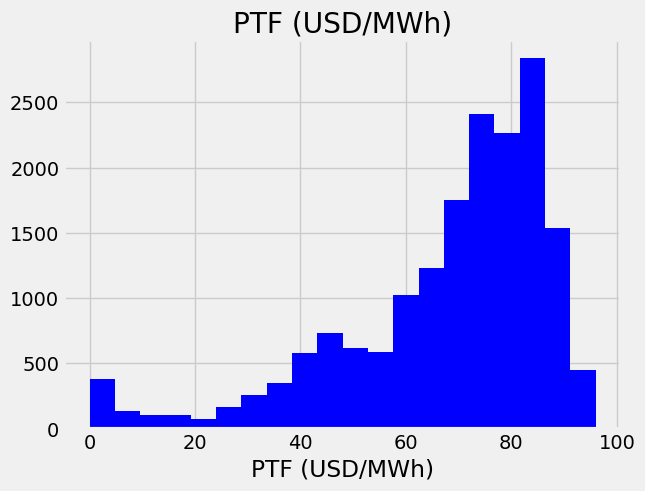


count    17568.000000
mean        61.638436
std         18.404453
min          0.000000
5%          23.123500
25%         54.190000
40%         62.950000
50%         66.620000
60%         69.450000
75%         74.150000
95%         82.350000
max         90.940000
Name: PTF (EUR/MWh), dtype: float64


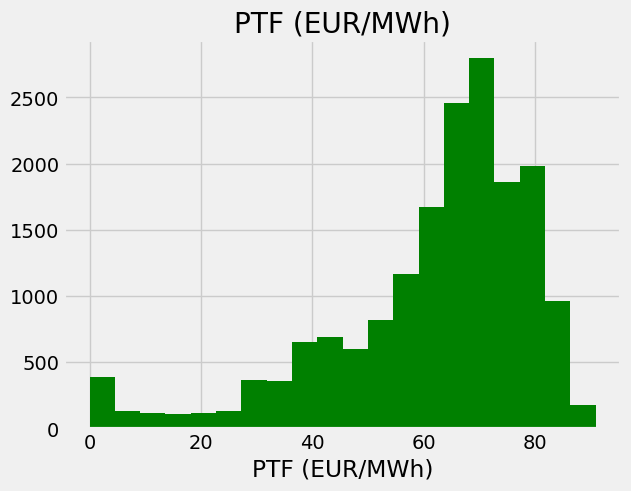


count                  17568
mean     2024-10-29 23:30:00
min      2023-10-30 00:00:00
5%       2023-12-05 14:21:00
25%      2024-04-29 23:45:00
40%      2024-08-17 18:48:00
50%      2024-10-29 23:30:00
60%      2025-01-11 04:12:00
75%      2025-04-30 23:15:00
95%      2025-09-24 08:39:00
max      2025-10-30 23:00:00
Name: Datetime, dtype: object


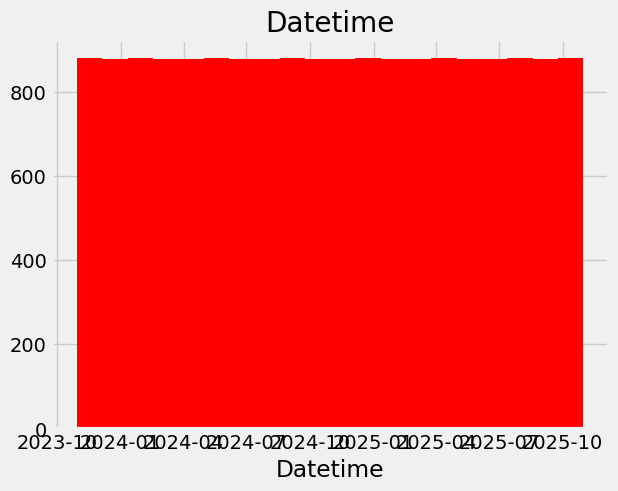


count    17568.000000
mean     36525.797676
std       6360.954413
min      11175.310000
5%       26898.219000
25%      32059.295000
40%      34482.484000
50%      36304.500000
60%      38143.792000
75%      41022.097500
95%      47091.219000
max      56219.060000
Name: Toplam, dtype: float64


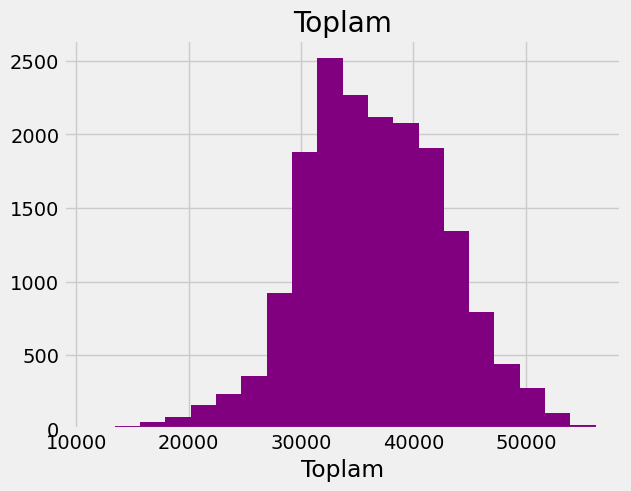


count    17568.000000
mean      7723.795008
std       4025.471434
min        276.290000
5%        1641.174500
25%       4342.345000
40%       6258.918000
50%       7575.245000
60%       8876.768000
75%      10753.297500
95%      14560.606000
max      18756.140000
Name: Doğal Gaz, dtype: float64


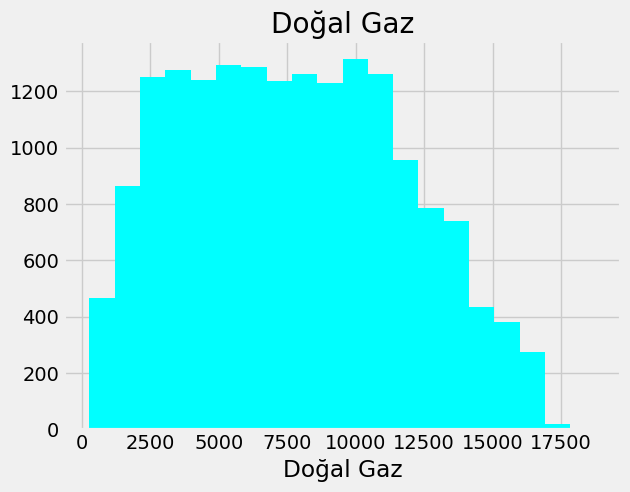


count    17568.000000
mean      5768.344981
std       2960.590317
min        394.820000
5%        1674.039500
25%       3400.827500
40%       4596.188000
50%       5354.275000
60%       6181.640000
75%       7714.017500
95%      11272.661500
max      16722.490000
Name: Barajlı, dtype: float64


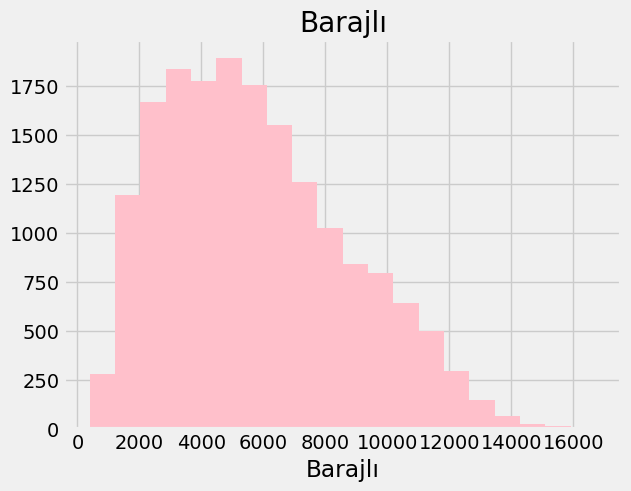


count    17568.000000
mean      4593.932971
std        603.940391
min       1701.420000
5%        3613.912000
25%       4282.215000
40%       4516.696000
50%       4642.150000
60%       4767.292000
75%       4963.895000
95%       5477.808500
max       6277.470000
Name: Linyit, dtype: float64


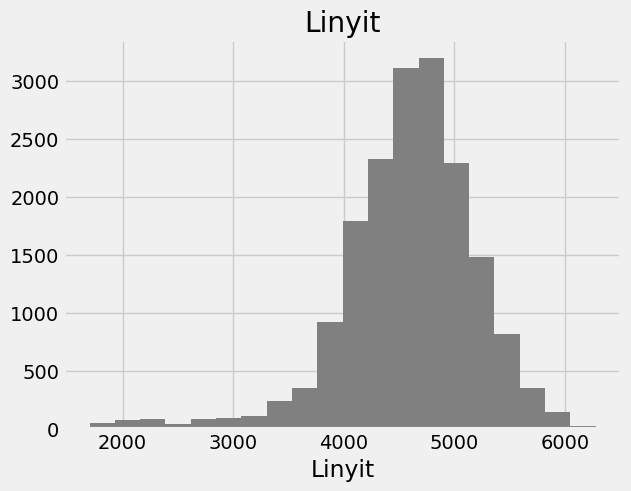


count    17568.000000
mean      1957.167973
std       1128.102274
min        268.150000
5%         679.454000
25%       1070.320000
40%       1383.218000
50%       1611.865000
60%       1919.700000
75%       2590.837500
95%       4300.697500
max       5466.400000
Name: Akarsu, dtype: float64


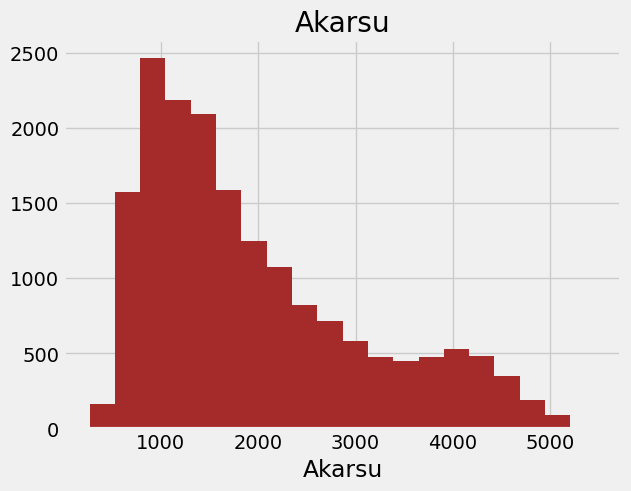


count    17568.000000
mean      8535.724566
std       1877.715968
min       1657.000000
5%        4618.953500
25%       7546.582500
40%       9009.946000
50%       9388.540000
60%       9673.382000
75%       9973.102500
95%      10108.246500
max      10172.670000
Name: İthal Kömür, dtype: float64


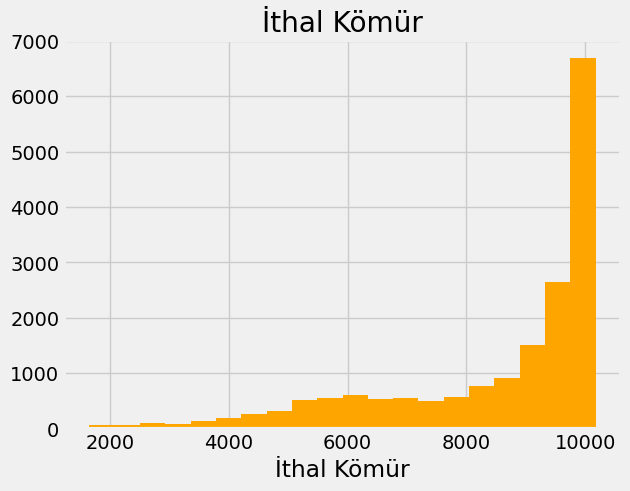


count    17568.000000
mean      4325.667778
std       2361.778929
min        127.050000
5%        1014.046500
25%       2311.892500
40%       3329.416000
50%       4049.755000
60%       4850.436000
75%       6182.900000
95%       8488.121500
max      10612.450000
Name: Rüzgar, dtype: float64


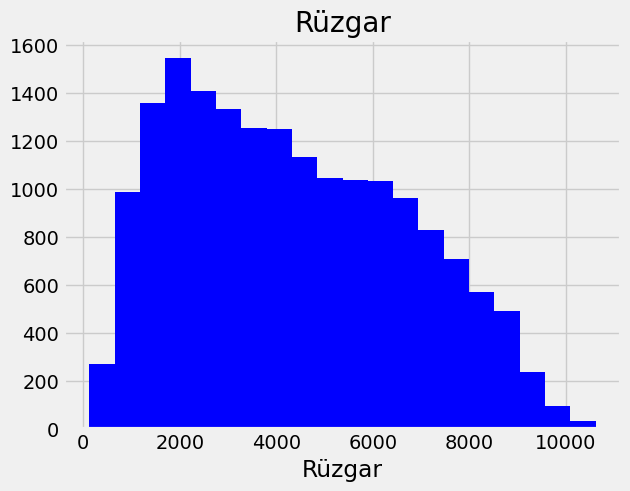


count    17568.000000
mean       717.919207
std        954.079721
min          0.000000
5%           0.010000
25%          0.010000
40%          1.230000
50%         40.505000
60%        484.312000
75%       1459.117500
95%       2741.403500
max       3394.370000
Name: Güneş, dtype: float64


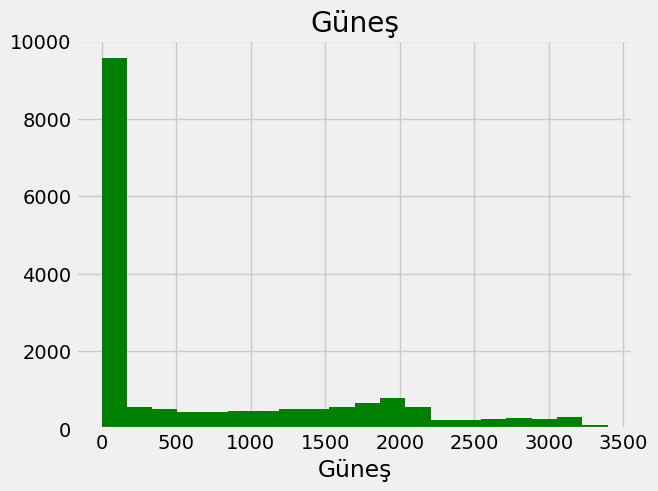


count    17568.000000
mean        85.253297
std         10.542810
min         26.700000
5%          62.697000
25%         81.530000
40%         86.000000
50%         87.980000
60%         89.720000
75%         92.630000
95%         96.466500
max        109.220000
Name: Fuel Oil, dtype: float64


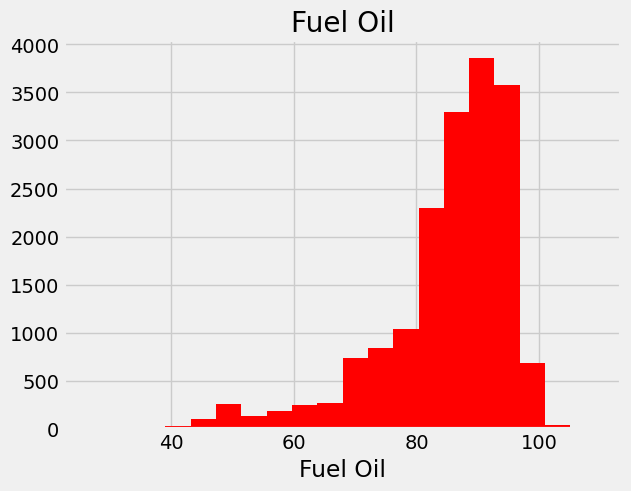


count    17568.000000
mean      1183.999788
std        137.902856
min        779.200000
5%         922.037500
25%       1085.552500
40%       1166.680000
50%       1211.235000
60%       1247.910000
75%       1297.375000
95%       1367.296500
max       1422.370000
Name: Jeotermal, dtype: float64


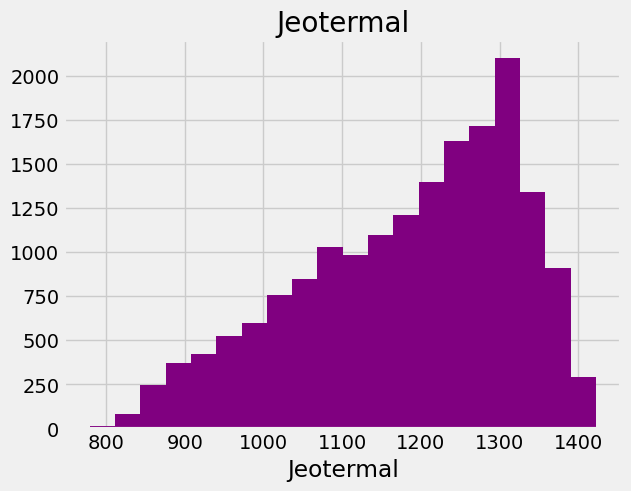


count    17568.000000
mean       167.753033
std         84.859621
min          0.000000
5%           0.000000
25%        114.810000
40%        163.380000
50%        203.130000
60%        214.170000
75%        220.800000
95%        311.320000
max        346.650000
Name: Asfaltit Kömür, dtype: float64


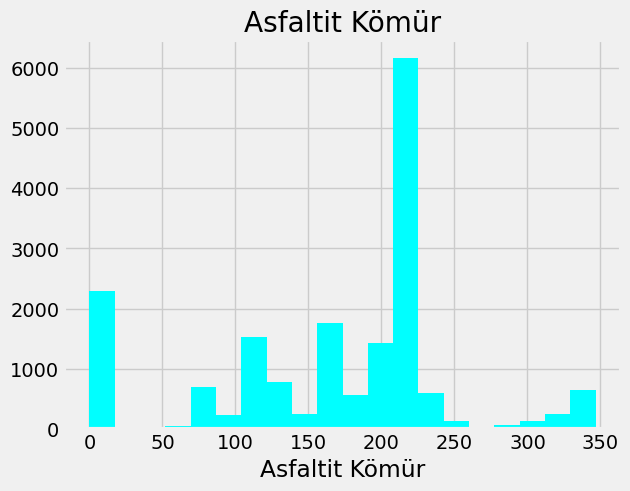


count    17568.000000
mean       518.192847
std         89.761158
min        215.390000
5%         323.911000
25%        446.255000
40%        512.984000
50%        555.970000
60%        572.220000
75%        591.032500
95%        618.396500
max        677.490000
Name: Taş Kömür, dtype: float64


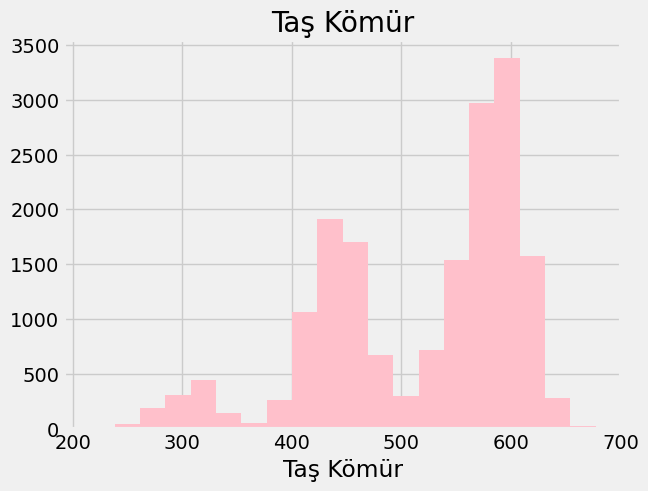


count    17568.000000
mean       967.235581
std         41.569713
min        495.190000
5%         894.020000
25%        942.947500
40%        961.130000
50%        970.840000
60%        980.352000
75%        996.100000
95%       1028.993000
max       1082.430000
Name: Biyokütle, dtype: float64


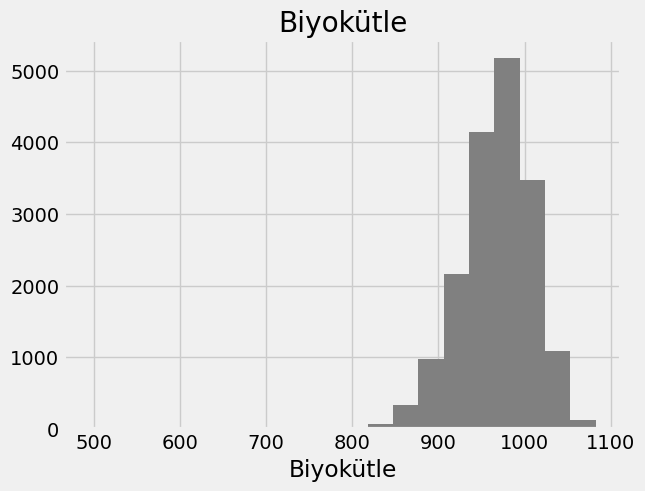


count    17568.000000
mean      -103.299597
std        425.685177
min      -1147.410000
5%        -762.749000
25%       -486.592500
40%       -173.124000
50%        -58.350000
60%         13.606000
75%        178.222500
95%        560.666500
max       7875.850000
Name: Uluslararası, dtype: float64


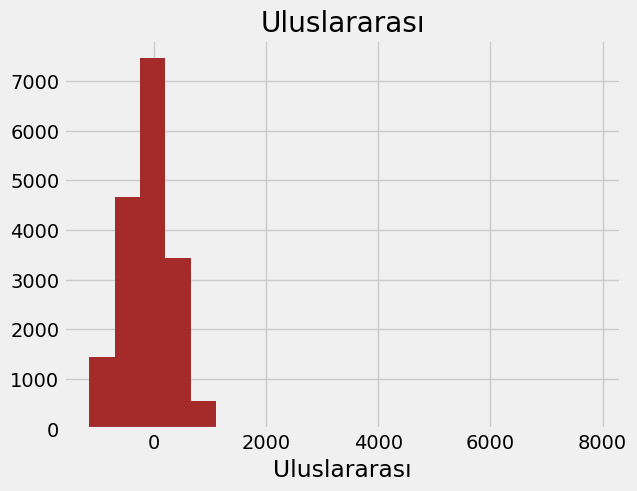


count    17568.000000
mean        84.111356
std         10.926117
min         40.470000
5%          67.050500
25%         76.540000
40%         81.048000
50%         83.905000
60%         86.912000
75%         91.870000
95%        101.970000
max        116.140000
Name: Atık Isı, dtype: float64


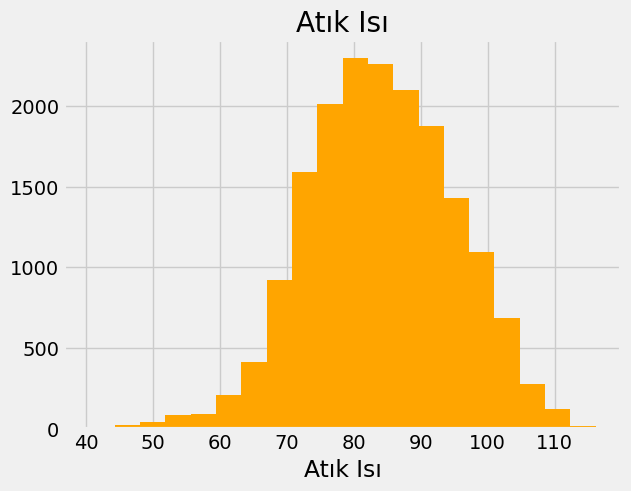


count    17568.000000
mean     39372.058780
std       6577.148934
min      20062.440000
5%       29444.223000
25%      34169.142500
40%      37606.666000
50%      39514.305000
60%      41138.254000
75%      43586.132500
95%      50980.948500
max      59503.670000
Name: Tüketim Miktarı(MWh), dtype: float64


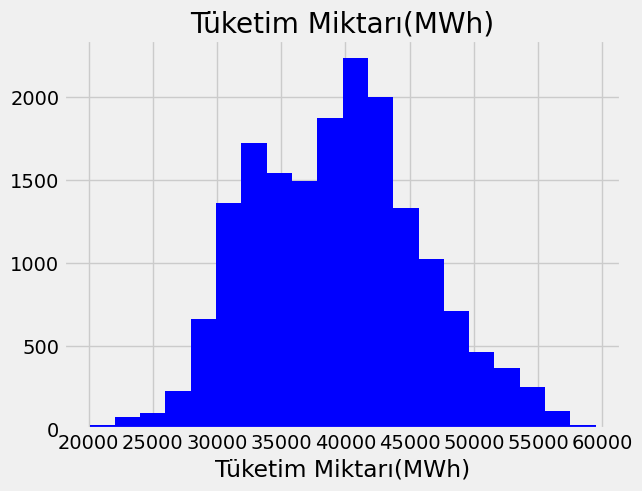

In [27]:
def num_summary(dataframe, col, plot=False,color='orange'):
    quantiles= [0.05, 0.25, 0.40, 0.60, 0.75, 0.95]
    print(dataframe[col].describe(quantiles).T)
    if plot:
        dataframe[col].hist(bins=20, color=color)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        print()

colors = ['orange', 'blue', 'green', 'red', 'purple', 'cyan', 'pink', 'gray', 'brown']
for i, col in enumerate(num_cols):
    num_summary(df, col, plot=True, color= colors[i % len(colors)])

## Outliers Problem

In [28]:
def outlier_thresholds(dataframe, col_name,  q1=0.05, q3=0.95):
    Q1 = dataframe[col_name].quantile(q1)
    Q3 = dataframe[col_name].quantile(q3)
    IQR = Q3 - Q1
    low = Q1 - 1.5*IQR
    up = Q3 + 1.5*IQR
    return low, up

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].shape[0] > 10:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].head(10))
    else:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )])
    if index:
      outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].index
      return outlier_index

number =1
for col in num_cols:
    print(number, '.', col.upper(), end='\n\n')
    grab_outliers(df, col)
    number += 1

1 . PTF (TL/MWH)

Empty DataFrame
Columns: [Tarih, Saat, PTF (TL/MWh), PTF (USD/MWh), PTF (EUR/MWh), Datetime, Toplam, Doğal Gaz, Barajlı, Linyit, Akarsu, İthal Kömür, Rüzgar, Güneş, Fuel Oil, Jeotermal, Asfaltit Kömür, Taş Kömür, Biyokütle, Uluslararası, Atık Isı, Tüketim Miktarı(MWh)]
Index: []
2 . PTF (USD/MWH)

Empty DataFrame
Columns: [Tarih, Saat, PTF (TL/MWh), PTF (USD/MWh), PTF (EUR/MWh), Datetime, Toplam, Doğal Gaz, Barajlı, Linyit, Akarsu, İthal Kömür, Rüzgar, Güneş, Fuel Oil, Jeotermal, Asfaltit Kömür, Taş Kömür, Biyokütle, Uluslararası, Atık Isı, Tüketim Miktarı(MWh)]
Index: []
3 . PTF (EUR/MWH)

Empty DataFrame
Columns: [Tarih, Saat, PTF (TL/MWh), PTF (USD/MWh), PTF (EUR/MWh), Datetime, Toplam, Doğal Gaz, Barajlı, Linyit, Akarsu, İthal Kömür, Rüzgar, Güneş, Fuel Oil, Jeotermal, Asfaltit Kömür, Taş Kömür, Biyokütle, Uluslararası, Atık Isı, Tüketim Miktarı(MWh)]
Index: []
4 . DATETIME

Empty DataFrame
Columns: [Tarih, Saat, PTF (TL/MWh), PTF (USD/MWh), PTF (EUR/MWh), Datetim

In [29]:
def replace_with_thresholds(dataframe, col):
    low, up = outlier_thresholds(dataframe,col)
    dataframe.loc[dataframe[col] < low, col] = low
    dataframe.loc[dataframe[col] > up, col] = up

for col in num_cols:
  replace_with_thresholds(df,col)

# Feature Engineering

## Seasonality

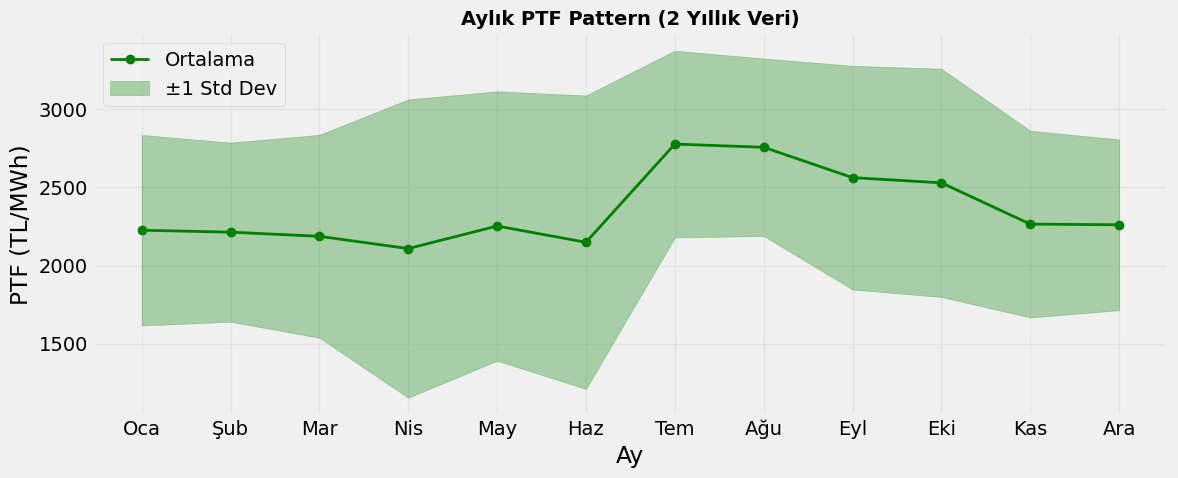

In [30]:
# Monthly Based PTF
df['Month'] = df['Datetime'].dt.month
monthly_avg = df.groupby('Month')['PTF (TL/MWh)'].agg(['mean', 'std'])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(monthly_avg.index, monthly_avg['mean'], marker='o', linewidth=2,
        color='green', label='Ortalama')
ax.fill_between(monthly_avg.index,
                monthly_avg['mean'] - monthly_avg['std'],
                monthly_avg['mean'] + monthly_avg['std'],
                alpha=0.3, color='green', label='±1 Std Dev')
ax.set_title('Aylık PTF Pattern (2 Yıllık Veri)', fontsize=14, fontweight='bold')
ax.set_xlabel('Ay')
ax.set_ylabel('PTF (TL/MWh)')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Oca', 'Şub', 'Mar', 'Nis', 'May', 'Haz',
                     'Tem', 'Ağu', 'Eyl', 'Eki', 'Kas', 'Ara'])
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Günlük Ortalama PTF')

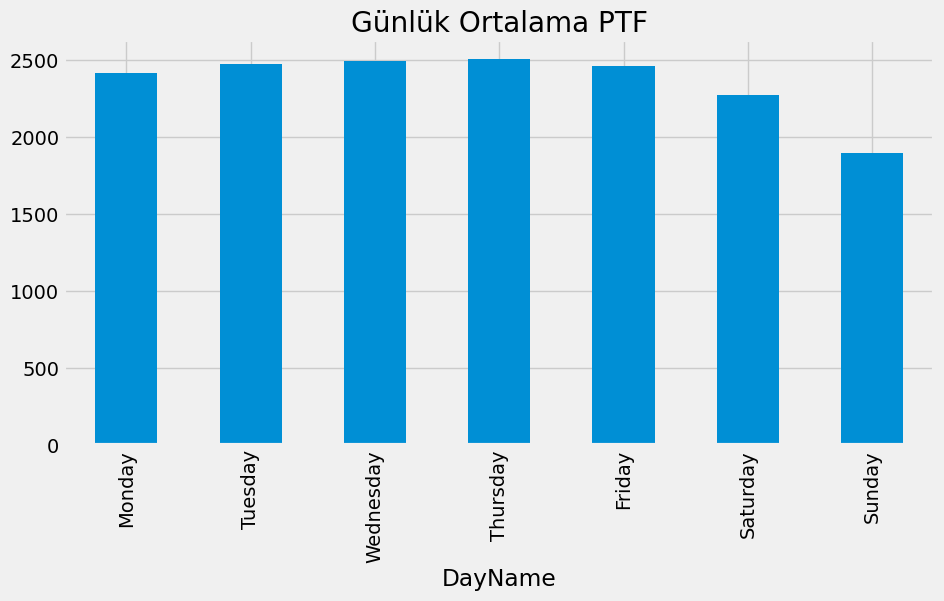

In [31]:
# Daily based - 0=Monday, 6=Sunday
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['DayName'] = df['Datetime'].dt.day_name()


daily_avg = df.groupby('DayName')['PTF (TL/MWh)'].mean()
# Sıralı göstermek için
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = daily_avg.reindex(day_order)
daily_avg.plot(kind='bar', figsize=(10,5))
plt.title('Günlük Ortalama PTF')

<Axes: title={'center': 'Hafta Sonu Saatlik PTF'}, xlabel='Saat'>

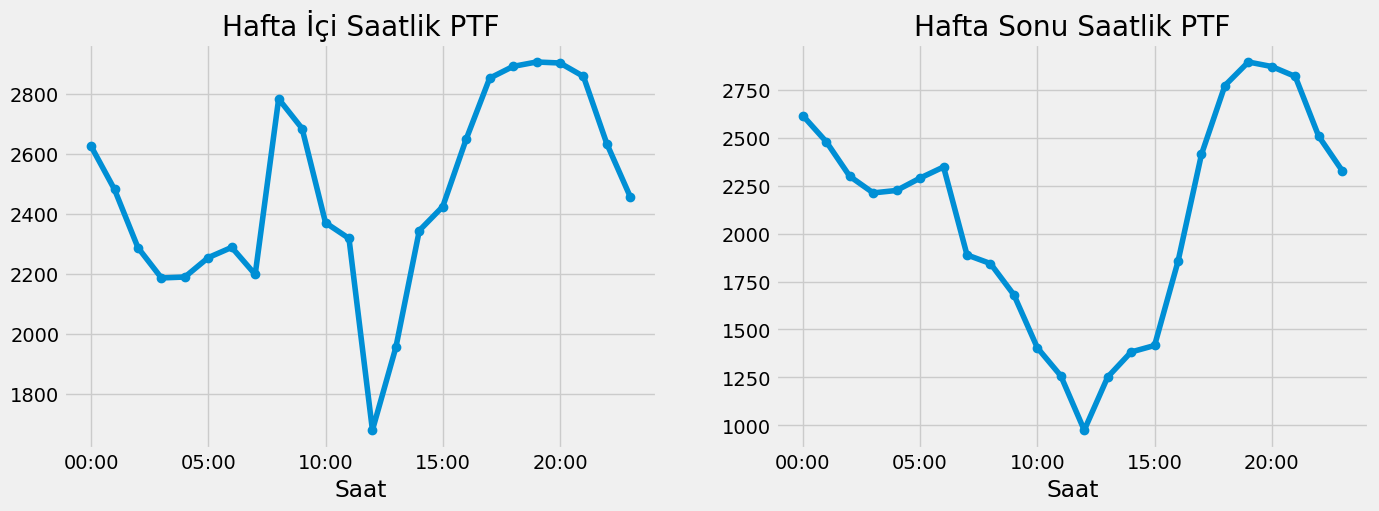

In [32]:
# Hafta içi vs hafta sonu ayrı ayrı
df['IsWeekend'] = df['DayOfWeek'].isin([5,6])

fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Hafta içi
weekday_hourly = df[~df['IsWeekend']].groupby('Saat')['PTF (TL/MWh)'].mean()
weekday_hourly.plot(ax=ax[0], marker='o', title='Hafta İçi Saatlik PTF')

# Hafta sonu
weekend_hourly = df[df['IsWeekend']].groupby('Saat')['PTF (TL/MWh)'].mean()
weekend_hourly.plot(ax=ax[1], marker='o', title='Hafta Sonu Saatlik PTF')

* We can conclude that electricity prices are cheap during the weekend daytime and high during weekday rush hour.
* The reason for the difference in the graphs around 7-9 o'clock may be the hours to go to work.

## Time Series Decomposition

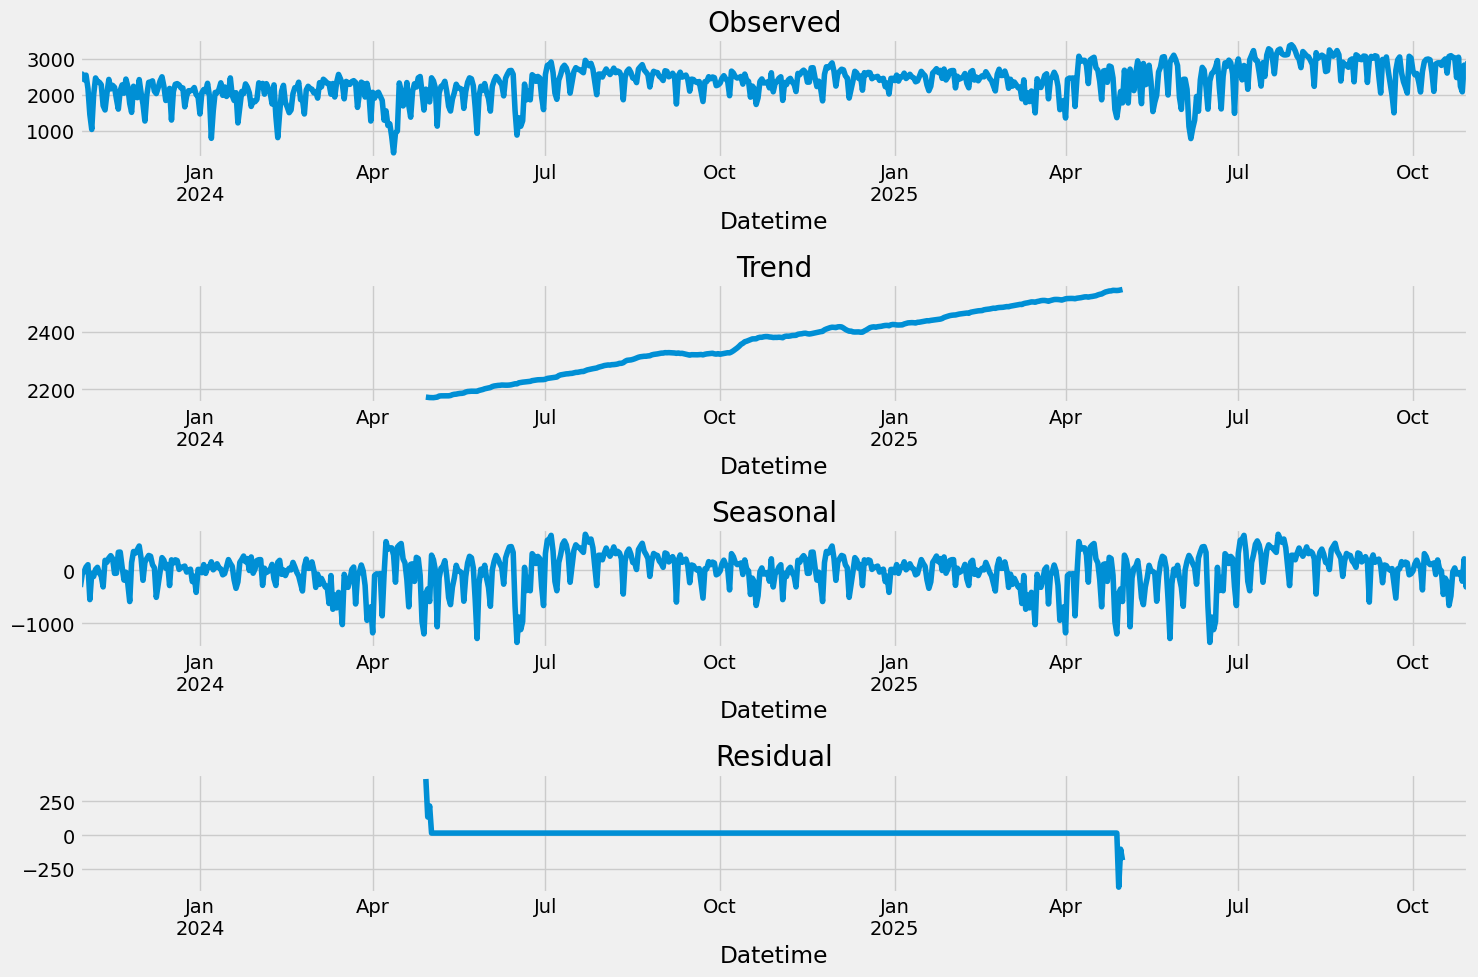

In [33]:
daily_ptf = df.set_index('Datetime')['PTF (TL/MWh)'].resample('D').mean()

# Decompose
decomposition = seasonal_decompose(daily_ptf, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15,10))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()

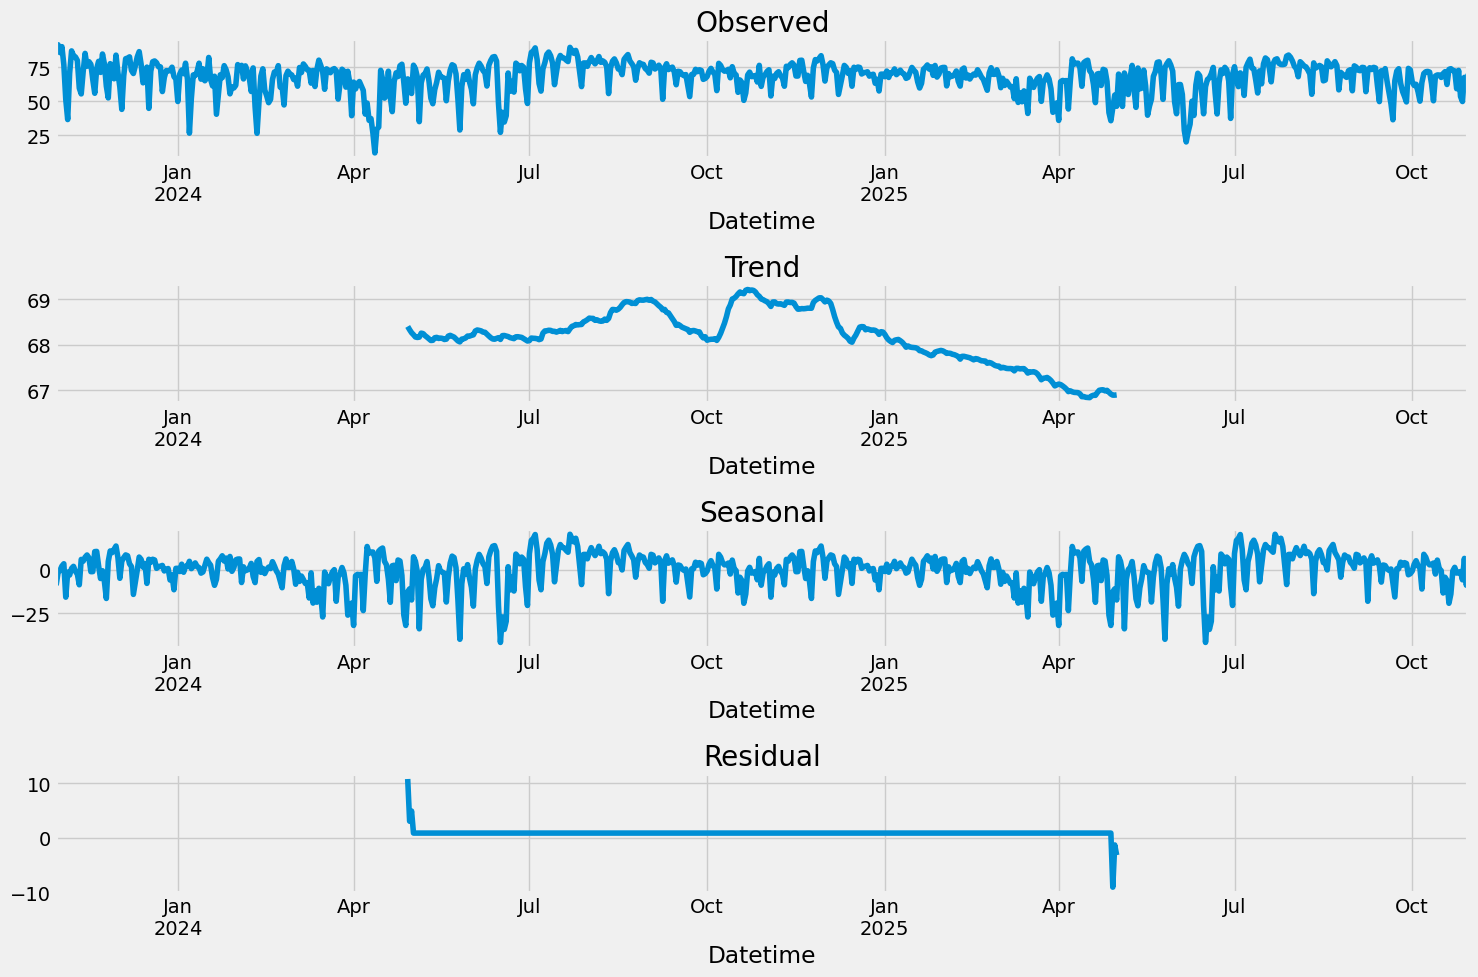

In [34]:
daily_ptf = df.set_index('Datetime')['PTF (USD/MWh)'].resample('D').mean()

# Decompose
decomposition = seasonal_decompose(daily_ptf, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15,10))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()

###

### Heatmap

Text(50.58333333333333, 0.5, 'Saatler')

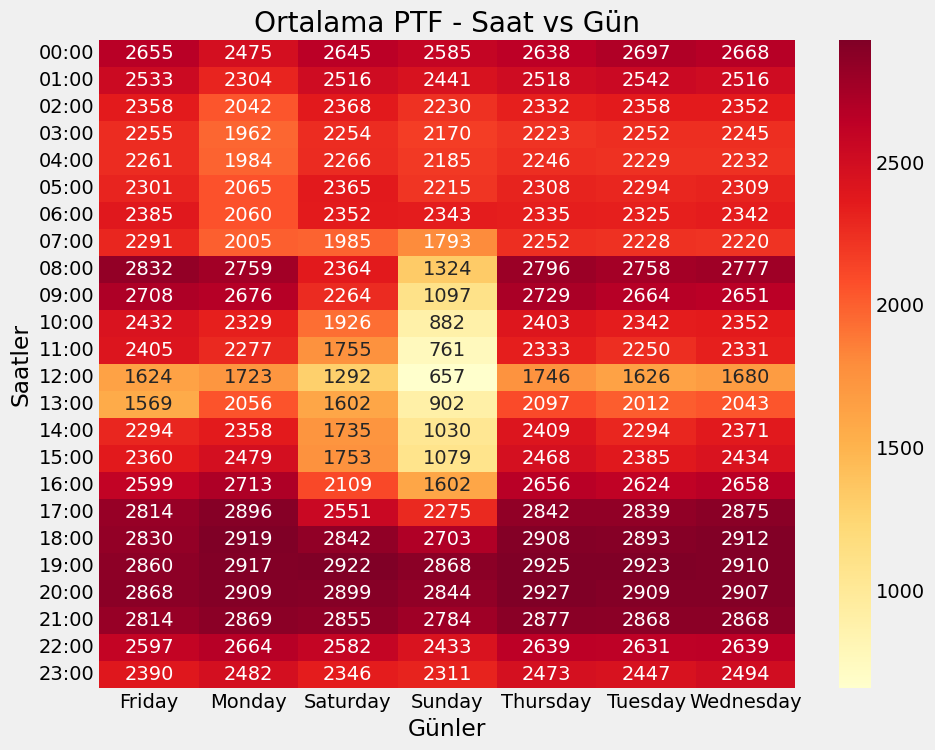

In [35]:
pivot_table = df.pivot_table(values='PTF (TL/MWh)',
                               index='Saat',
                               columns='DayName',
                               aggfunc='mean')

plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Ortalama PTF - Saat vs Gün')
plt.xlabel('Günler')
plt.ylabel('Saatler')

## Renewable Energy Analysis

Renewable Share vs PTF correlation: -0.433



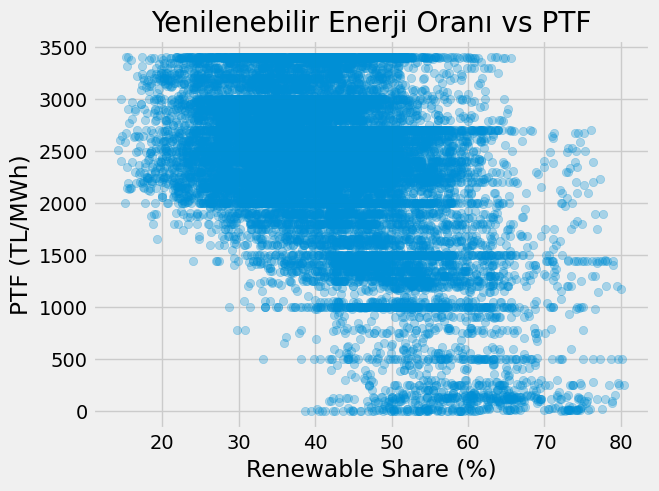

In [36]:
# Renewable penetration
df['Renewable_Total'] = df['Rüzgar'] + df['Güneş'] + df['Barajlı'] + df['Akarsu'] + df['Biyokütle'] + df['Jeotermal'] + df['Atık Isı']
df['Renewable_Share'] = df['Renewable_Total'] / df['Toplam'] * 100

# Scatter plot
plt.scatter(df['Renewable_Share'], df['PTF (TL/MWh)'], alpha=0.3)
plt.xlabel('Renewable Share (%)')
plt.ylabel('PTF (TL/MWh)')
plt.title('Yenilenebilir Enerji Oranı vs PTF')

# Correlation
print(f"Renewable Share vs PTF correlation: {df['Renewable_Share'].corr(df['PTF (USD/MWh)']):.3f}", end='\n\n')

* As the renewable energy rate increases, the PTF decreases.
* In other words, there is an inverse correlation between the two.

## Fossil Fuel Share

In [37]:
df['Fossil_Share'] = (df['Doğal Gaz'] + df['İthal Kömür'] + df['Asfaltit Kömür'] + df['Taş Kömür'] + df['Fuel Oil']) / df['Toplam']

## Supply-Demand Balance

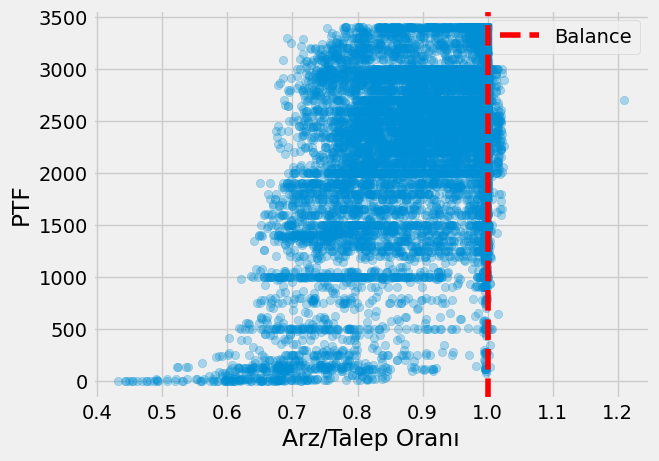

In [38]:
df['Supply_Demand_Ratio'] = df['Toplam'] / df['Tüketim Miktarı(MWh)']
df['Supply_Demand_Gap'] = df['Toplam'] - df['Tüketim Miktarı(MWh)']

plt.scatter(df['Supply_Demand_Ratio'], df['PTF (TL/MWh)'], alpha=0.3)
plt.xlabel('Arz/Talep Oranı')
plt.ylabel('PTF')
plt.axvline(x=1, color='r', linestyle='--', label='Balance')
plt.legend()

* In general, it appears that supply is not meeting demand. Türkiye is a country dependent on foreign energy.

In [39]:
# Yüksek talep + düşük renewable = yüksek fiyat
df['Demand_x_LowRenewable'] = df['Tüketim Miktarı(MWh)'] * (1 - df['Renewable_Share'])

## Extreme Events

In [40]:
# En pahalı 100 saat
top_100 = df.nlargest(100, 'PTF (TL/MWh)')

# Bunlar hangi saatlerde/günlerde oluyor?
print(top_100['Saat'].value_counts().head(), end='\n\n')
print(top_100['Month'].value_counts().head(), end='\n\n')
print(top_100['DayOfWeek'].value_counts().head(), end='\n\n')

# Renewable share bu saatlerde nasıl?
print(f"Avg renewable share in top 100 expensive hours: {top_100['Renewable_Share'].mean():.1f}%")

Saat
20:00    35
19:00    27
21:00    25
22:00     6
18:00     5
Name: count, dtype: int64

Month
4    69
5    31
Name: count, dtype: int64

DayOfWeek
4    18
5    17
0    16
1    15
6    12
Name: count, dtype: int64

Avg renewable share in top 100 expensive hours: 50.5%


* Expensive Hours: between 18-22
* Expensive Months: April and May
* Expensive Days: not certain

In [41]:
df['Saat'].dtypes

dtype('O')

In [42]:
df['Saat'] = df['Saat'].str[0:2].astype(int)

In [43]:
df['IsPeakHour'] = df['Saat'].isin([18, 19, 20, 21, 22]).astype(int)

# Peak saat + yüksek talep
df['Peak_x_Demand'] = df['IsPeakHour'] * df['Tüketim Miktarı(MWh)']

## Lag features

In [44]:
# Geçmiş PTF değerleri - önceki saatin fiyatı güçlü predictor
df['PTF_lag1'] = df['PTF (TL/MWh)'].shift(1)  # 1 saat önceki fiyat
df['PTF_lag24'] = df['PTF (TL/MWh)'].shift(24)  # Dün aynı saat
df['PTF_lag168'] = df['PTF (TL/MWh)'].shift(168)  # Geçen hafta aynı saat

## Rolling Statistics

In [45]:
# Son 24 saatin ortalaması
df['PTF_rolling_24h_mean'] = df['PTF (TL/MWh)'].shift(1).rolling(24).mean()
df['PTF_rolling_weekly_mean'] = df['PTF (TL/MWh)'].shift(1).rolling(168).mean()
df['PTF_rolling_24h_std'] = df['PTF (TL/MWh)'].shift(1).rolling(24).std()
df['PTF_rolling_weekly_std'] = df['PTF (TL/MWh)'].shift(1).rolling(168).std()

## Cyclic features

In [46]:
# Cyclic features - saatlik ve aylık döngüsellik
# Modelin saat 0 ile saat 23'ün çok farklı olmadığını anlaması için bu işlem gerekiyor.
df['Saat'] = df['Saat'].astype(int)
df['Month'] = df['Month'].astype(int)
df['DayOfWeek'] = df['DayOfWeek'].astype(int)

df['Hour_sin'] = np.sin(2 * np.pi * df['Saat'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Saat'] / 24)

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

print("Cyclic features oluşturuldu:")
print(df[['Saat', 'Hour_sin', 'Hour_cos']].head())

Cyclic features oluşturuldu:
   Saat  Hour_sin  Hour_cos
0     0  0.000000  1.000000
1     1  0.258819  0.965926
2     2  0.500000  0.866025
3     3  0.707107  0.707107
4     4  0.866025  0.500000


## Holidays

In [47]:
# Türkiye resmi tatilleri
holidays = ['2023-10-29','2024-01-01', '2024-04-10','2024-04-11','2024-04-12','2024-04-23', '2024-05-01', '2024-05-19',
            '2024-06-15','2024-06-16','2024-06-17','2024-06-18', '2024-07-15', '2024-08-30', '2024-10-29',
            '2025-01-01', '2025-03-29','2025-03-30','2025-03-31','2025-04-01', '2025-05-01', '2025-05-19',
            '2025-06-06','2025-06-07','2025-06-08','2025-06-09', '2025-07-15', '2025-08-30', '2025-10-29']
df['IsHoliday'] = df['Datetime'].dt.date.astype(str).isin(holidays).astype(int)

## Exponentially Weighted Mean Features

In [48]:
#Exponentially Weighted Mean Features
"""
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['Transaction_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.8, 0.5]
lags = [24, 168, 720]

df = ewm_features(df, alphas, lags)
"""

'\ndef ewm_features(dataframe, alphas, lags):\n    for alpha in alphas:\n        for lag in lags:\n            dataframe[\'Transaction_ewm_alpha_\' + str(alpha).replace(".", "") + "_lag_" + str(lag)] =                 dataframe.groupby(["merchant_id"])[\'Total_Transaction\'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())\n    return dataframe\n\nalphas = [0.95, 0.8, 0.5]\nlags = [24, 168, 720]\n\ndf = ewm_features(df, alphas, lags)\n'

# Selection of Variables

In [49]:
df.head()

Tarih  Saat  PTF (TL/MWh)  PTF (USD/MWh)  PTF (EUR/MWh)            Datetime    Toplam  Doğal Gaz  Barajlı   Linyit  Akarsu  İthal Kömür   Rüzgar  Güneş  Fuel Oil  Jeotermal  Asfaltit Kömür  Taş Kömür  Biyokütle  Uluslararası  Atık Isı  Tüketim Miktarı(MWh)  Month  DayOfWeek DayName  IsWeekend  Renewable_Total  Renewable_Share  Fossil_Share  Supply_Demand_Ratio  Supply_Demand_Gap  Demand_x_LowRenewable  IsPeakHour  Peak_x_Demand  PTF_lag1  PTF_lag24  PTF_lag168  PTF_rolling_24h_mean  \
0  30.10.2023     0       1877.99          66.77          63.25 2023-10-30 00:00:00  29018.05    5336.31  3601.22  5017.91  718.35      8629.80  1978.26    0.0     87.48    1206.71          211.96     542.96    1013.41        583.33     90.35              29051.28     10          0  Monday      False          8608.30        29.665329      0.510321             0.998856             -33.23         -832764.498882           0            0.0       NaN        NaN         NaN                   NaN   
1  30.10.2023     1       2319.00          82.45          78.11 2023-10-30 01:00:00  27831.72    5446.44  2230.86  5108.86  609.64      8801.59  1922.98    0.0     80.40    1215.07          214.17     545.70    1000.38        563.70     91.93              27868.07     10          0  Monday      False          7070.86        25.405760      0.542126             0.998696             -36.35         -680141.429378           0            0.0   1877.99        NaN         NaN                   NaN   
2  30.10.2023     2       1799.97          64.00          60.63 2023-10-30 02:00:00  27038.60    5206.16  1645.89  5213.35  528.03      8727.27  1808.66    0.0     79.80    1222.38          216.38     541.77    1010.78        743.26     94.87              27073.08     10          0  Monday      False          6310.61        23.339263      0.546307             0.998726             -34.48         -604792.657793           0            0.0   2319.00        NaN         NaN                   NaN   
3  30.10.2023     3       2100.00          74.66          70.73 2023-10-30 03:00:00  26574.14    5188.83  1310.30  5015.00  474.82      8883.20  1776.25    0.0     79.67    1226.56          214.17     549.20    1016.82        751.85     87.47              26606.03     10          0  Monday      False          5892.22        22.172759      0.561263             0.998801             -31.89         -563323.059282           0            0.0   1799.97        NaN         NaN                   NaN   
4  30.10.2023     4       1799.97          64.00          60.63 2023-10-30 04:00:00  26453.59    4983.44  1316.78  5003.02  426.47      8772.16  1750.65    0.0     79.67    1235.91          216.38     544.38    1030.97       1005.32     88.44              26483.97     10          0  Monday      False          5849.22        22.111252      0.551760             0.998853             -30.38         -559109.769842           0            0.0   2100.00        NaN         NaN                   NaN   

   PTF_rolling_weekly_mean  PTF_rolling_24h_std  PTF_rolling_weekly_std  Hour_sin  Hour_cos  Month_sin  Month_cos  DayOfWeek_sin  DayOfWeek_cos  IsHoliday  
0                      NaN                  NaN                     NaN  0.000000  1.000000  -0.866025        0.5            0.0            1.0          0  
1                      NaN                  NaN                     NaN  0.258819  0.965926  -0.866025        0.5            0.0            1.0          0  
2                      NaN                  NaN                     NaN  0.500000  0.866025  -0.866025        0.5            0.0            1.0          0  
3                      NaN                  NaN                     NaN  0.707107  0.707107  -0.866025        0.5            0.0            1.0          0  
4                      NaN                  NaN                     NaN  0.866025  0.500000  -0.866025        0.5            0.0            1.0          0

## Encoding

In [50]:
target_col = 'PTF (TL/MWh)'
cycling_cols = ['Hour_sin','Hour_cos','Month_sin','Month_cos','DayOfWeek_sin',	'DayOfWeek_cos'] # They are already in scaled form.

In [51]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 17568
Variables: 48
cat_cols: 7
num_cols: 40
cat_but_car: 1
num_but_cat: 6


In [52]:
cat_cols = [col for col in cat_cols if col not in cycling_cols and col not in ['DayOfWeek','DayName']]
num_cols = [col for col in num_cols if col not in cycling_cols]

In [53]:
cat_cols

['IsWeekend', 'IsPeakHour', 'IsHoliday']

In [54]:
num_cols

['Saat',
 'PTF (TL/MWh)',
 'PTF (USD/MWh)',
 'PTF (EUR/MWh)',
 'Datetime',
 'Toplam',
 'Doğal Gaz',
 'Barajlı',
 'Linyit',
 'Akarsu',
 'İthal Kömür',
 'Rüzgar',
 'Güneş',
 'Fuel Oil',
 'Jeotermal',
 'Asfaltit Kömür',
 'Taş Kömür',
 'Biyokütle',
 'Uluslararası',
 'Atık Isı',
 'Tüketim Miktarı(MWh)',
 'Month',
 'Renewable_Total',
 'Renewable_Share',
 'Fossil_Share',
 'Supply_Demand_Ratio',
 'Supply_Demand_Gap',
 'Demand_x_LowRenewable',
 'Peak_x_Demand',
 'PTF_lag1',
 'PTF_lag24',
 'PTF_lag168',
 'PTF_rolling_24h_mean',
 'PTF_rolling_weekly_mean',
 'PTF_rolling_24h_std',
 'PTF_rolling_weekly_std']

In [55]:
# We choose the correct numeric variables.
num_cols = [ # Main generation
            'Doğal Gaz', 'Rüzgar', 'Barajlı', 'Uluslararası', 'Güneş',

            # Shares
            'Renewable_Share','Fossil_Share',

            # Demand/Supply
            'Toplam', 'Tüketim Miktarı(MWh)', 'Supply_Demand_Ratio',

            # Lag and Rolling Features
            'PTF_lag1', 'PTF_lag24', 'PTF_lag168', 'PTF_rolling_24h_mean',
            'PTF_rolling_weekly_mean','PTF_rolling_24h_std', 'PTF_rolling_weekly_std']

In [56]:
df_ = df.copy()

In [57]:
df = df[cat_cols + num_cols + cycling_cols + [target_col]]

In [58]:
df['IsWeekend'] = df['IsWeekend'].astype(int)

In [59]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

#df = one_hot_encoder(df, cat_cols, drop_first=True)

# We did not use this function because our categorical cols already are the way zero-one

In [60]:
df[cat_cols].value_counts().head()

IsWeekend  IsPeakHour  IsHoliday
0          0           0            9576
1          0           0            3800
0          1           0            2520
1          1           0            1000
0          0           1             380
Name: count, dtype: int64

# Scaling

In [61]:
# Important! We use df_ because we seperated some columns like Datetime for modelling.

In [62]:
df_['Datetime'].min(), df_['Datetime'].max()

(Timestamp('2023-10-30 00:00:00'), Timestamp('2025-10-30 23:00:00'))

In [63]:
split_date = '2025-07-30 00:00:00'
train = df[df_['Datetime']<= split_date]
test = df[df_['Datetime']> split_date]

In [64]:
train_ = df_[df_['Datetime']<= split_date]
test_ = df_[df_['Datetime']> split_date]

In [65]:
len(train), len(test)

(15337, 2231)

In [66]:
X_train = train.drop('PTF (TL/MWh)', axis=1)
y_train = train['PTF (TL/MWh)']
X_test = test.drop('PTF (TL/MWh)', axis=1)
y_test = test['PTF (TL/MWh)']

In [67]:
#StandardScaler
"""
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

# We did not use Scaler because we will use Tree-based algorithms.

'\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n'

# MODEL

In [68]:
# We did not use train_test_split method because we already splitted test and train sets.

## Baseline

In [69]:
# Naive forecast - dün aynı saat
y_pred_baseline = test['PTF_lag24']

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

print("=== BASELINE (PTF_lag24) ===")
print(f"MAE: {mae_baseline:.2f}")
print(f"RMSE: {rmse_baseline:.2f}")
print(f"R²: {r2_baseline:.3f}")

=== BASELINE (PTF_lag24) ===
MAE: 394.35
RMSE: 696.04
R²: 0.176


## Random Forest

In [70]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\n=== RANDOM FOREST ===")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.3f}")


=== RANDOM FOREST ===
MAE: 202.55
RMSE: 297.20
R²: 0.850


## XGBoost

In [71]:
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n=== XGBOOST ===")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.3f}")


=== XGBOOST ===
MAE: 201.88
RMSE: 282.82
R²: 0.864


## LGBM

In [72]:
lgb_model = LGBMRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print("\n=== LIGHTGBM ===")
print(f"MAE: {mae_lgb:.2f}")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"R²: {r2_lgb:.3f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4417
[LightGBM] [Info] Number of data points in the train set: 15337, number of used features: 26
[LightGBM] [Info] Start training from score 2293.728146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

=== LIGHTGBM ===
MAE: 180.57
RMSE: 268.30
R²: 0.878


## Comparison Results

In [88]:
results = pd.DataFrame({
    'Model': ['Baseline', 'Random Forest', 'XGBoost', 'LightGBM'],
    'MAE': [mae_baseline, mae_rf, mae_xgb, mae_lgb],
    'RMSE': [rmse_baseline, rmse_rf, rmse_xgb, rmse_lgb],
    'R²': [r2_baseline, r2_rf, r2_xgb, r2_lgb]
})

print("\n=== MODEL Comparison ===")
print(results.to_string(index=False))


=== MODEL Comparison ===
        Model        MAE       RMSE       R²
     Baseline 394.352577 696.040622 0.176328
Random Forest 202.551367 297.195593 0.849835
      XGBoost 201.879111 282.823280 0.864007
     LightGBM 180.572762 268.299890 0.877616


* Day-ahead price estimation in academic literature:

* R² > 0.80: Excellent ✓
* MAPE < 15%: Good (~7-8% of your value)
* MAE < 200: Strong ✓

# Feature Importance


=== TOP 10 FEATURES ===
                Feature  Importance
13             PTF_lag1         558
20             Hour_sin         436
3             Doğal Gaz         401
15           PTF_lag168         371
14            PTF_lag24         345
21             Hour_cos         320
12  Supply_Demand_Ratio         303
5               Barajlı         289
10               Toplam         285
4                Rüzgar         278


<Figure size 1000x600 with 0 Axes>

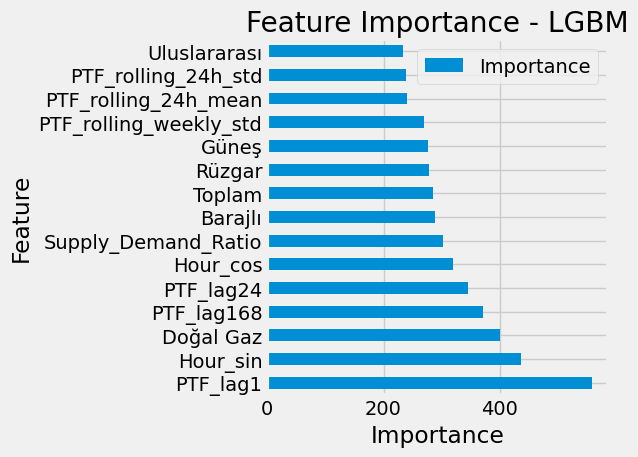

In [74]:
# LGBM feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== TOP 10 FEATURES ===")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(x='Feature', y='Importance', kind='barh')
plt.title('Feature Importance - LGBM')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Residuals
* Are residuals random or is there a pattern?

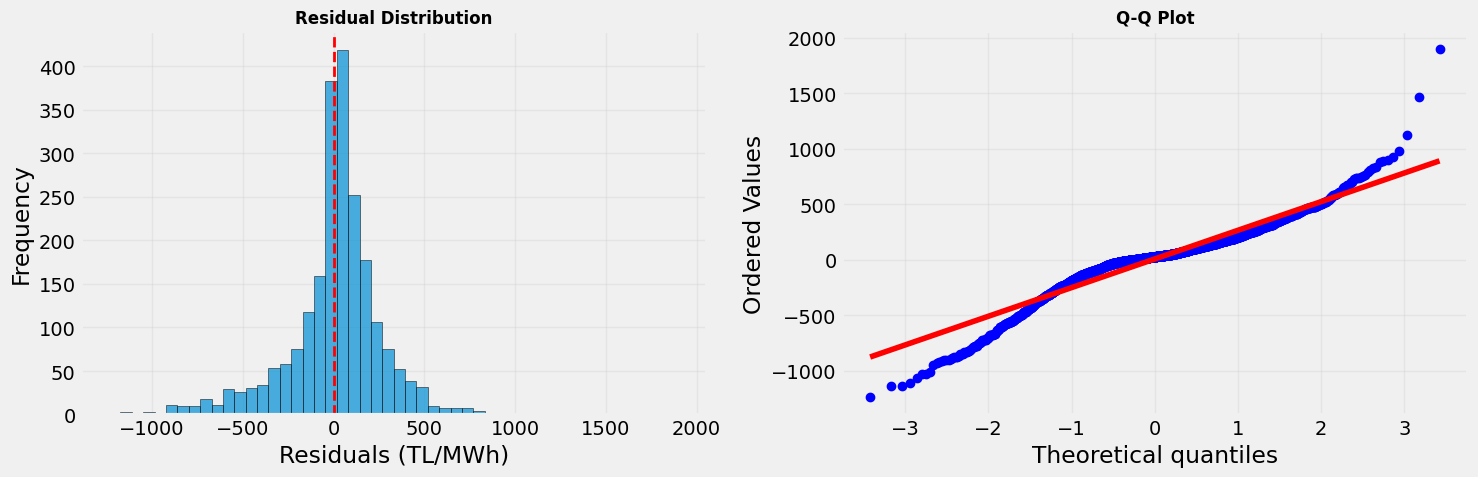

In [75]:
residuals = y_test - y_pred_lgb

# A) Residual Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Residuals (TL/MWh)')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

# QQ Plot - normality control
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

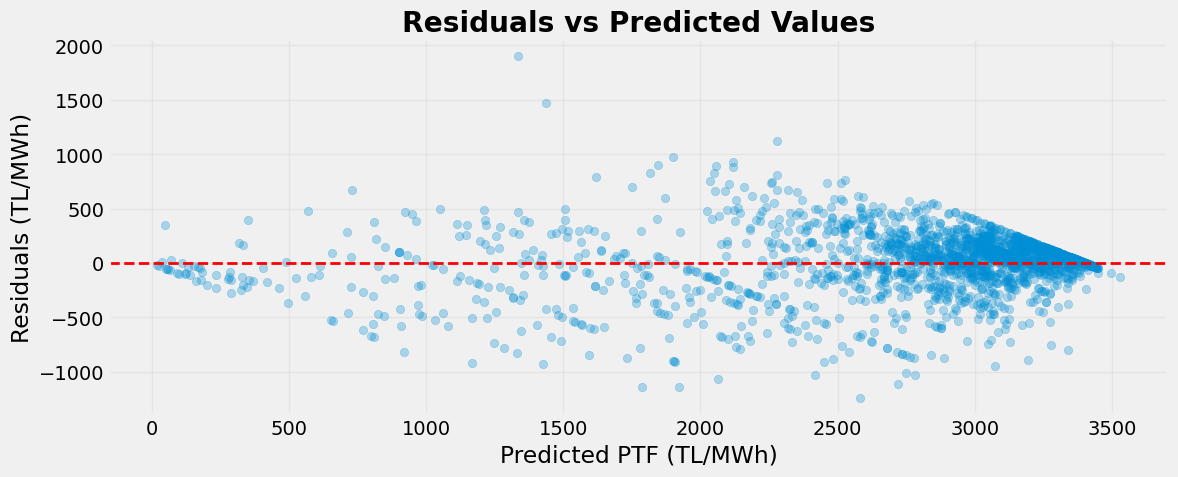

In [76]:
# B) Residuals vs Predicted Values
plt.figure(figsize=(12, 5))
plt.scatter(y_pred_lgb, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted PTF (TL/MWh)')
plt.ylabel('Residuals (TL/MWh)')
plt.title('Residuals vs Predicted Values', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


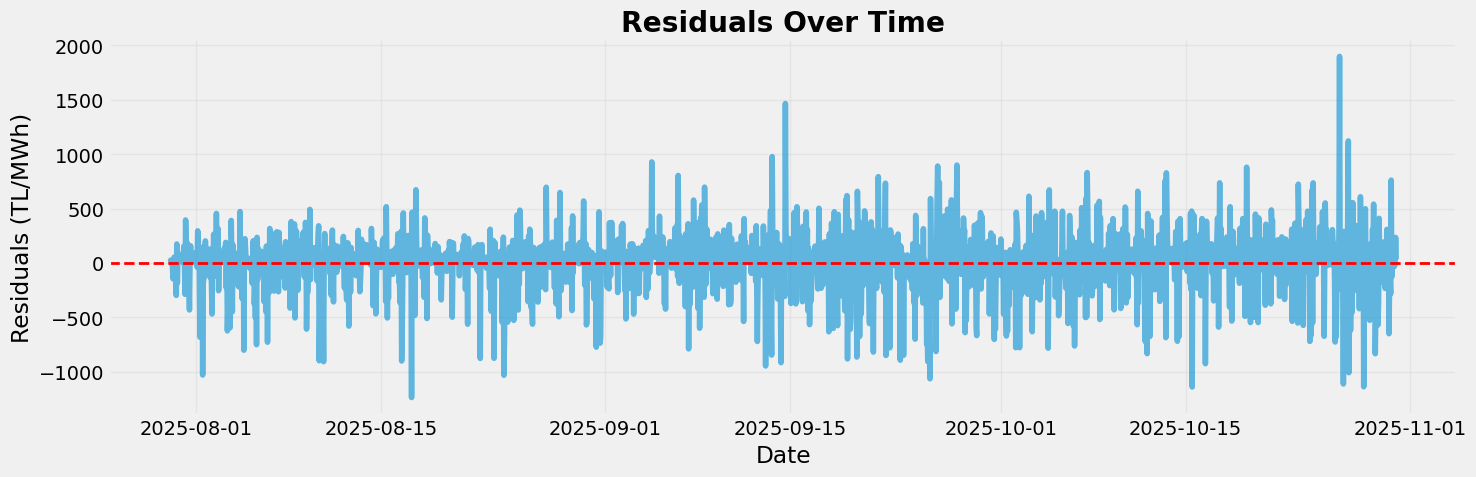

=== RESIDUAL ANALİZİ ===
Mean: 7.09 (0'a yakın olmalı)
Std Dev: 268.27
Min: -1237.59
Max: 1899.45

Skewness: -0.486 (0'a yakın = simetrik)
Kurtosis: 3.823 (0'a yakın = normal)


In [77]:
# C) Residuals Over Time
test_with_pred = test_.copy()
test_with_pred['Predictions'] = y_pred_lgb
test_with_pred['Residuals'] = residuals

plt.figure(figsize=(15, 5))
plt.plot(test_with_pred['Datetime'], test_with_pred['Residuals'], alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Residuals (TL/MWh)')
plt.title('Residuals Over Time', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# İstatistikler
print("=== RESIDUAL ANALİZİ ===")
print(f"Mean: {residuals.mean():.2f} (0'a yakın olmalı)")
print(f"Std Dev: {residuals.std():.2f}")
print(f"Min: {residuals.min():.2f}")
print(f"Max: {residuals.max():.2f}")
print(f"\nSkewness: {stats.skew(residuals):.3f} (0'a yakın = simetrik)")
print(f"Kurtosis: {stats.kurtosis(residuals):.3f} (0'a yakın = normal)")

# Prediction Plot

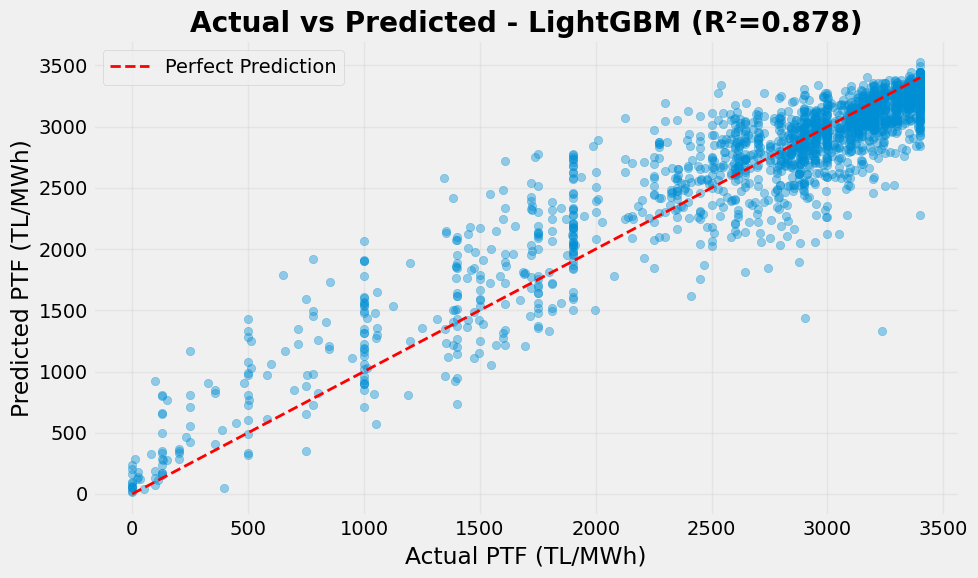

In [79]:
# A) Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lgb, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual PTF (TL/MWh)')
plt.ylabel('Predicted PTF (TL/MWh)')
plt.title(f'Actual vs Predicted - LightGBM (R²={r2_lgb:.3f})', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


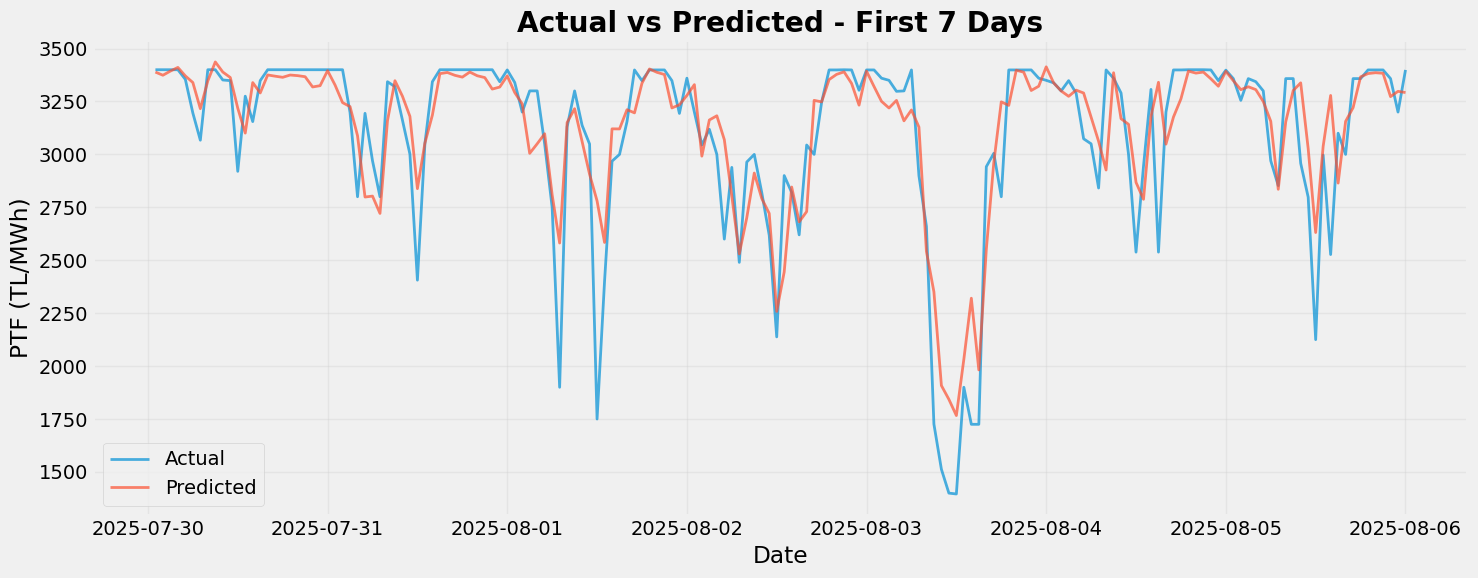

In [80]:

# B) Time Series Plot (First 7 days)
plt.figure(figsize=(15, 6))
plot_days = 7 * 24  # 7 gün
plt.plot(test_with_pred['Datetime'][:plot_days],
         test_with_pred['PTF (TL/MWh)'][:plot_days],
         label='Actual', linewidth=2, alpha=0.7)
plt.plot(test_with_pred['Datetime'][:plot_days],
         test_with_pred['Predictions'][:plot_days],
         label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('PTF (TL/MWh)')
plt.title('Actual vs Predicted - First 7 Days', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



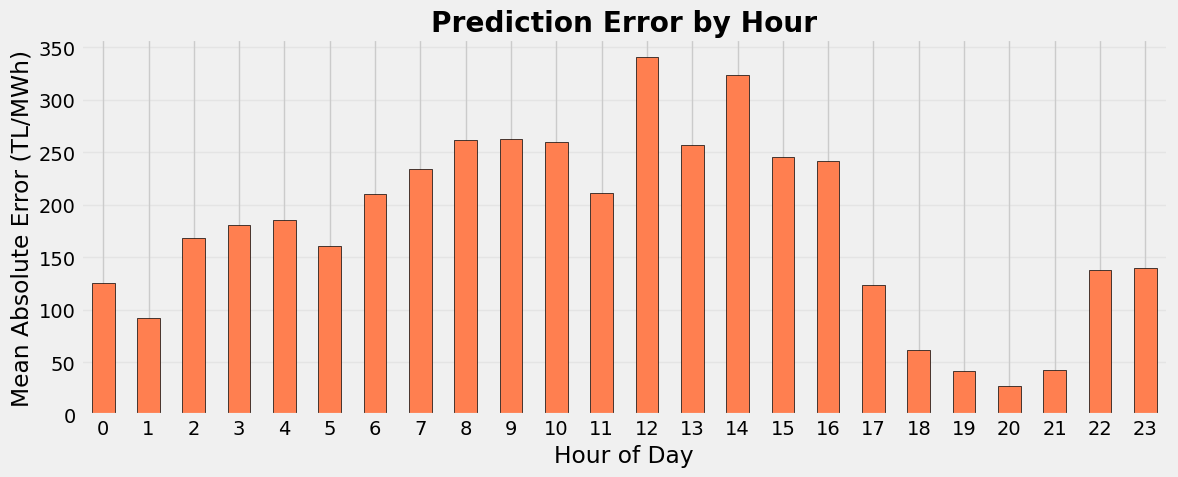

In [81]:
# C) Error Distribution by Hour
test_with_pred['Hour'] = test_with_pred['Datetime'].dt.hour
test_with_pred['Absolute_Error'] = abs(test_with_pred['Residuals'])

hourly_error = test_with_pred.groupby('Hour')['Absolute_Error'].mean()

plt.figure(figsize=(12, 5))
hourly_error.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Absolute Error (TL/MWh)')
plt.title('Prediction Error by Hour', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Trading Strategy

=== TRADING STRATEGY RESULTS ===
Total PnL: 228219.65 TL
Win Rate: 59.7%
Total Trades: 1919
Profitable Trades: 1145
Sharpe Ratio: 21.18
Max Drawdown: -6369.95 TL


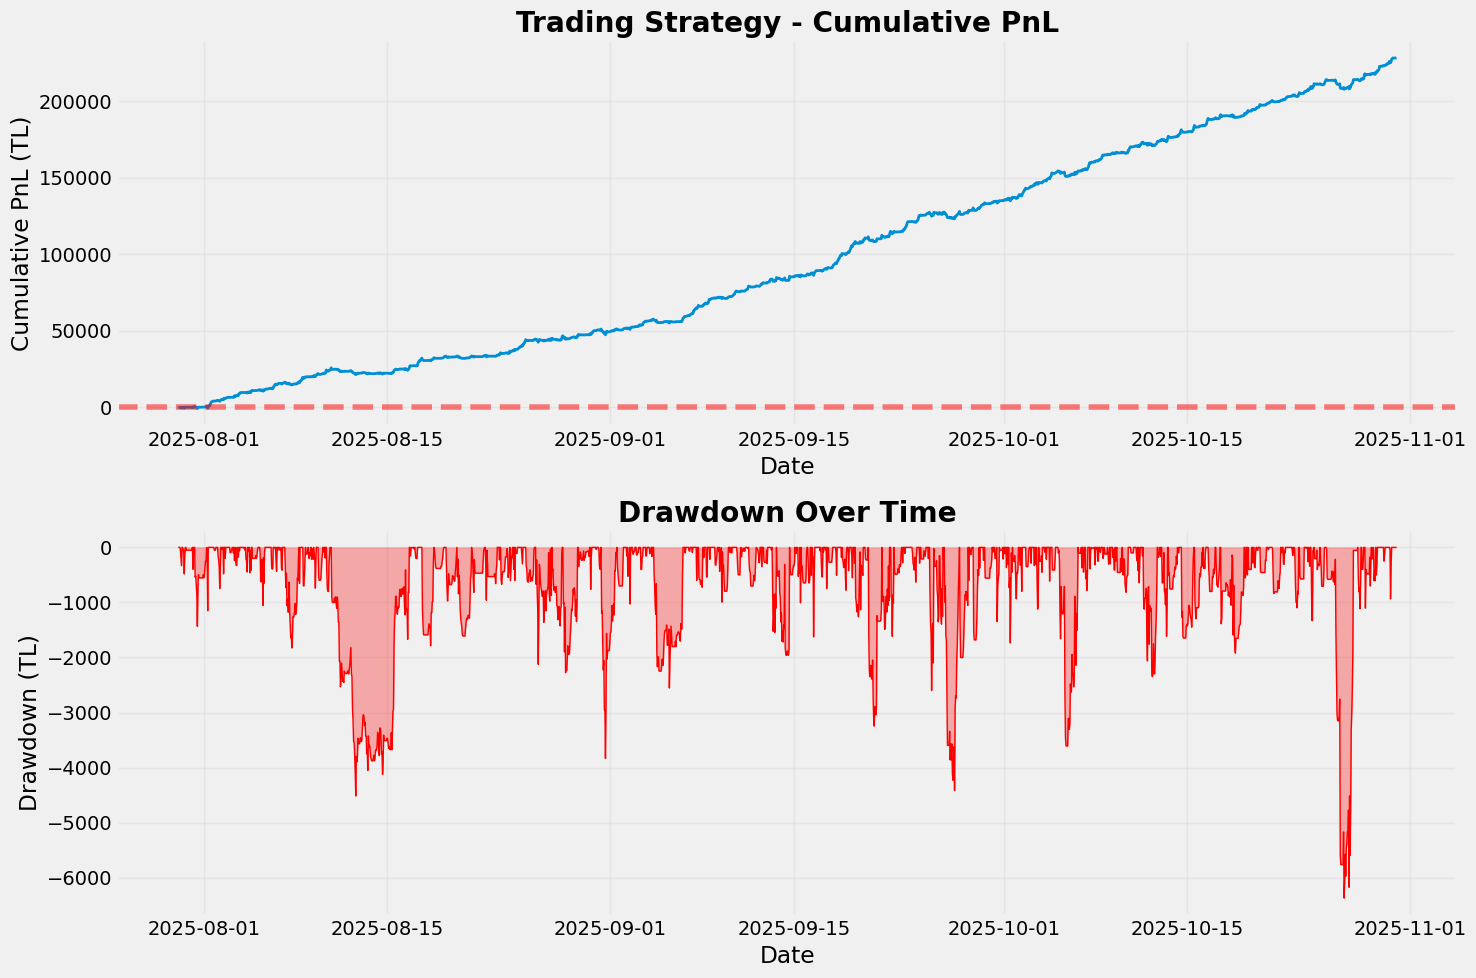

In [92]:
#At 2:00 PM:
# Actual PTF = 2000 TL
# Predicted 3:00 PM PTF = 2100 TL

# Forecast > Actual → Signal = 1 (LONG)
# In other words: "Price will rise, BUY"


test_with_pred['Price_Change'] = test_with_pred['PTF (TL/MWh)'].diff()

test_with_pred['Signal'] = 0
test_with_pred.loc[test_with_pred['Predictions'] > test_with_pred['PTF (TL/MWh)'], 'Signal'] = 1  # LONG
test_with_pred.loc[test_with_pred['Predictions'] < test_with_pred['PTF (TL/MWh)'], 'Signal'] = -1  # SHORT

test_with_pred['PnL'] = test_with_pred['Signal'].shift(1) * test_with_pred['Price_Change']
test_with_pred['PnL'] = test_with_pred['PnL'].fillna(0)

# Cumulative PnL
test_with_pred['Cumulative_PnL'] = test_with_pred['PnL'].cumsum()

# Metrics
total_pnl = test_with_pred['PnL'].sum()
profitable_trades = (test_with_pred['PnL'] > 0).sum()
total_trades = (test_with_pred['PnL'] != 0).sum()
win_rate = (profitable_trades / total_trades * 100) if total_trades > 0 else 0

# Sharpe ratio (daily returns)
daily_returns = test_with_pred['PnL']
sharpe = (daily_returns.mean() / daily_returns.std() * np.sqrt(24*365)) if daily_returns.std() > 0 else 0

# Maximum drawdown
cumulative = test_with_pred['Cumulative_PnL']
running_max = cumulative.expanding().max()
drawdown = cumulative - running_max
max_drawdown = drawdown.min()

print("=== TRADING STRATEGY RESULTS ===")
print(f"Total PnL: {total_pnl:.2f} TL")
print(f"Win Rate: {win_rate:.1f}%")
print(f"Total Trades: {total_trades}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f} TL")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Cumulative PnL
axes[0].plot(test_with_pred['Datetime'], test_with_pred['Cumulative_PnL'], linewidth=2)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cumulative PnL (TL)')
axes[0].set_title('Trading Strategy - Cumulative PnL', fontweight='bold')
axes[0].grid(alpha=0.3)

# Drawdown
axes[1].fill_between(test_with_pred['Datetime'], drawdown, 0, alpha=0.3, color='red')
axes[1].plot(test_with_pred['Datetime'], drawdown, color='red', linewidth=1)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown (TL)')
axes[1].set_title('Drawdown Over Time', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()